In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, InputLayer, Flatten
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import fidle
import random

C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
from keras import backend as K
def val_mse(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred), axis=-1)
    return mse

In [ ]:
def denormalize(mean, std, seq):
    nseq = seq.copy()
    for i, s in enumerate(nseq):
        s = s * std + mean
        nseq[i] = s
    return nseq

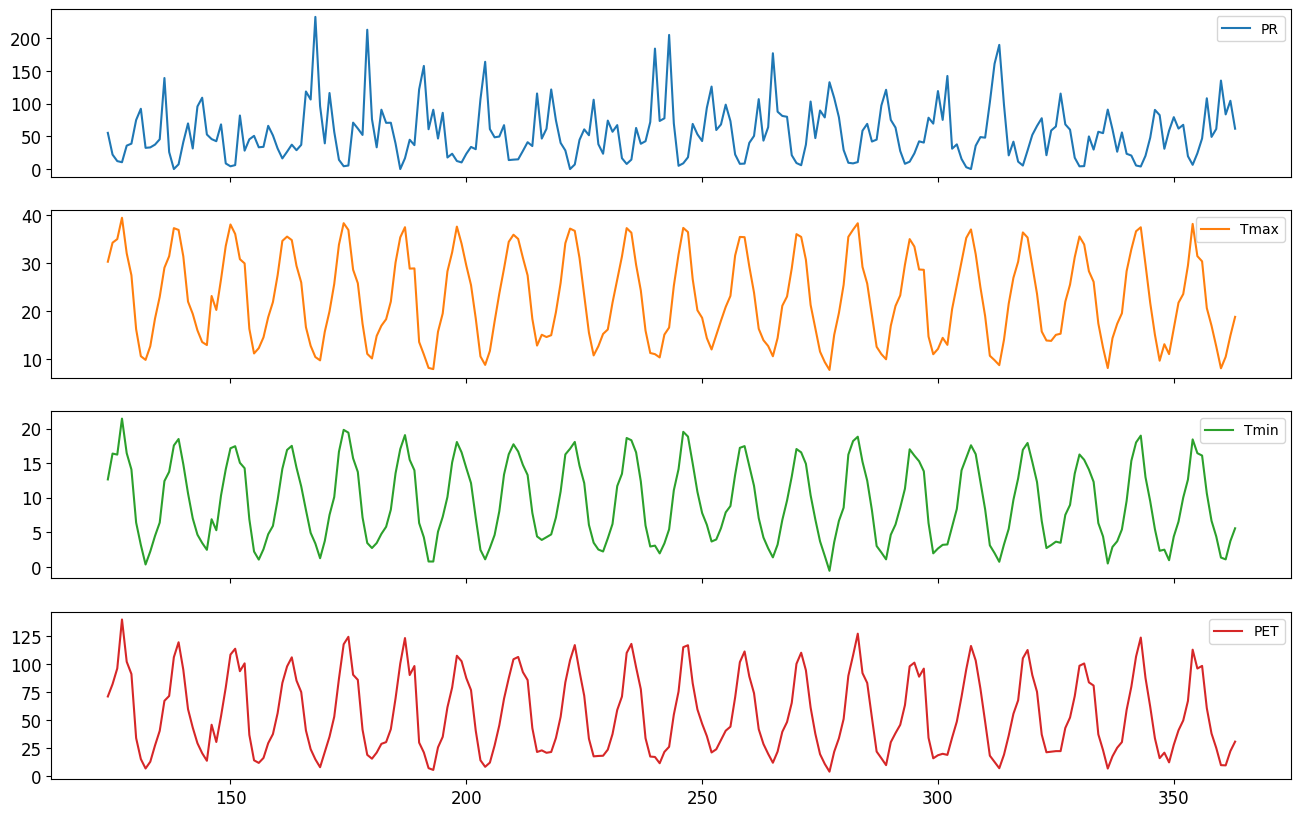

<Figure size 640x480 with 0 Axes>

In [ ]:
df = pd.read_excel('Taoura.xlsx', sheet_name='Feuil1')
df.head()

cols=["Year","Month"]
df['Date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

df.drop(['Year', 'Month'], axis = 1, inplace = True)

cols = df.columns.tolist()
#cols

cols = cols[-1:] + cols[:-1]
#cols

df = df[cols]
#df.head()

columns_na = df.isna().sum().tolist()
columns_na

#df.shape

#df.describe(include='all')

i = random.randint(0, len(df)-240)
df.iloc[i:i+240].plot(subplots = True, fontsize = 12, figsize = (16,10))
plt.show()
plt.savefig('description.png')

In [ ]:
features = ['PR', 'Tmax', 'Tmin', 'PET']
features_len = len(features)
#dates = df['Date']

#scale = 1
train_prop = .8
sequence_len = 12 # 12 mois
learning_rate = 0.001
batch_size = 64
epochs= 100

#df = df[:int(scale * len(df))]
df = df[:len(df)]
train_len = int(train_prop * len(df))

dataset_train = df.loc[ :train_len-1, features]
dataset_test = df.loc[train_len:, features]
#print("=====Train Dataset Example=========")
#display(dataset_train.head(5))

#df.drop('Date', axis = 1, inplace = True)

#df.columns

mean = dataset_train.mean()
print('Moyenne:\n',mean)
std = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test = (dataset_test - mean) / std
#display(dataset_train.describe().style.format('{0:.2f}'))

dataset_train = dataset_train.to_numpy()
dataset_test = dataset_test.to_numpy()

print('Dataset: ', df.shape)
print('Train dataset: ', dataset_train.shape)
print('Test dataset: ', dataset_test.shape)

from keras.preprocessing.sequence import TimeseriesGenerator

train_generator = TimeseriesGenerator(dataset_train, dataset_train, length = sequence_len, batch_size = batch_size)
test_generator = TimeseriesGenerator(dataset_test, dataset_test, length = sequence_len, batch_size = batch_size)

x, y = train_generator[0]
x_val, y_val = test_generator[0]
print(f'nombre de batches disponibles: ', len(train_generator))
print('train batch x shape: ', x.shape)
print('train batch y shape: ', y.shape)

print('What a train batch looks like (x):')
print(x[0])
print('What a train batch looks like (y):')
print(y[0])
print('=======================================================================')
print('validation batch x shape: ', x_val.shape)
print('validation batch y shape: ', y_val.shape)
print('What a validation batch looks like (x):')
print(x_val[0])
print('What a validation batch looks like (y):')
print(y_val[0])

Moyenne:
 PR      53.294211
Tmax    23.006721
Tmin     9.492785
PET     56.066860
dtype: float64
Dataset:  (372, 5)
Train dataset:  (297, 4)
Test dataset:  (75, 4)
nombre de batches disponibles:  5
train batch x shape:  (64, 12, 4)
train batch y shape:  (64, 4)
What a train batch looks like (x):
[[-0.24899588 -1.21080959 -1.36544113 -1.19572101]
 [-0.24244899 -0.92325748 -1.21434583 -1.07898668]
 [ 0.29354887 -0.41106494 -0.72688148 -0.64544113]
 [ 0.98782362 -0.23479224 -0.75956765 -0.6205807 ]
 [-0.46742172  0.40992462 -0.055748   -0.08143997]
 [-0.75701357  0.66156272  0.70752828  0.26682498]
 [-1.08022236  1.44120273  1.50891969  1.34551109]
 [-1.02882021  1.41995782  1.71896482  1.76668397]
 [-0.71608544  0.88034923  1.08706971  1.15237219]
 [-0.17921768  0.08584979  0.31155016  0.34248571]
 [-0.07366539 -0.32409286 -0.24422699 -0.17818453]
 [ 0.02356752 -0.67932688 -0.4775231  -0.4524147 ]]
What a train batch looks like (y):
[ 2.90191959 -1.33611852 -1.0492502  -1.10521891]
valid

# **LSTM MODEL**

In [ ]:
model = tf.keras.models.load_model('../model.h5', custom_objects={"val_mse": val_mse })
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 256)           267264    
                                                                 
 dropout (Dropout)           (None, 12, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 12, 256)           394240    
                                                                 
 dropout_2 (Dropout)         (None, 12, 256)           0         
                                                                 
 flatten (Flatten)           (None, 3072)              0

In [ ]:
pip install pydot

  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


(13, 4)
1/1 [==============================] - 4s 4s/step


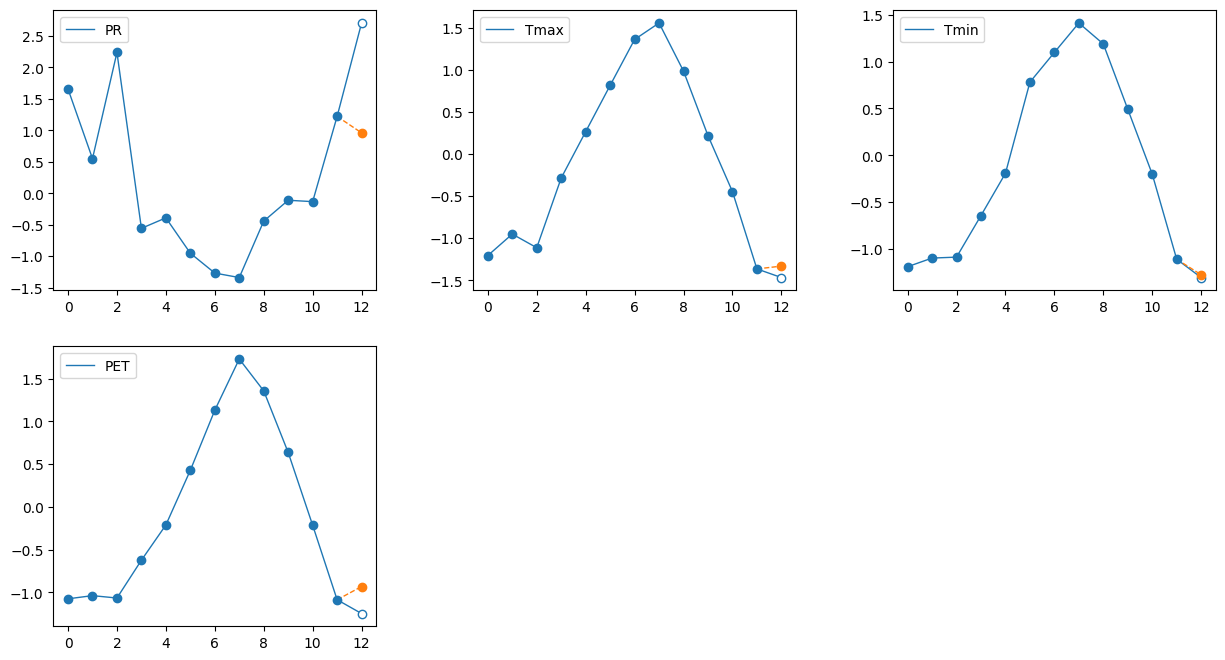

In [ ]:
s = random.randint(0, len(dataset_test) - sequence_len)

sequence = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

print(sequence_true.shape)

pred = model.predict(np.array([sequence]))

fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm.png')

(13, 4)
1/1 [==============================] - 0s 103ms/step


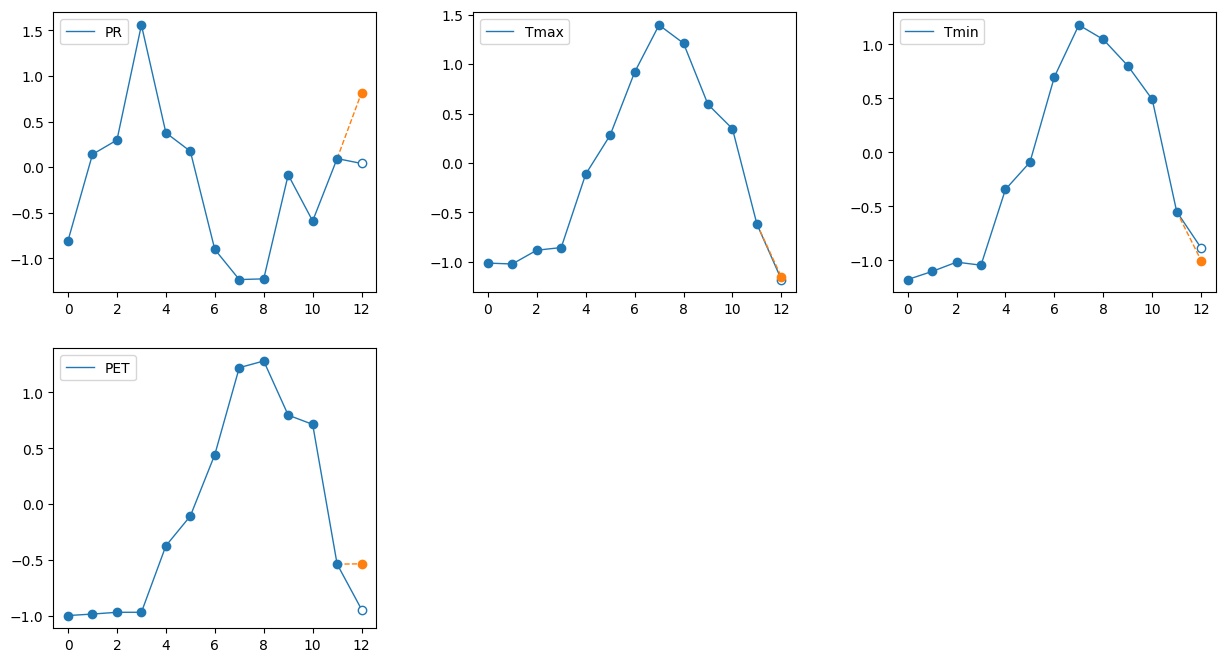

In [ ]:
s = random.randint(0, len(dataset_test) - sequence_len)

sequence = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

print(sequence_true.shape)

pred = model.predict(np.array([sequence]))

fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm.png')

[[ 21.187       13.93709677   2.72419355  21.38821983]
 [ 58.8583      13.85645161   3.15322581  21.85421562]
 [ 65.1119      15.10517241   3.65        22.40333939]
 [115.3423      15.34354839   3.48870968  22.40673828]
 [ 68.2832      21.98666667   7.52        43.06610107]
 [ 60.1996      25.52096774   8.96290323  52.34415436]
 [ 17.3184      31.22        13.50333333  71.44412994]
 [  4.1817      35.50483871  16.26290323  98.49041748]
 [  4.4836      33.85        15.49516129 100.56028748]
 [ 49.8993      28.31        14.09666667  83.72399902]
 [ 29.7589      26.10483871  12.30483871  80.84855652]
 [ 57.0071      17.47         6.33666667  37.3843956 ]
 [ 54.8723      12.44677419   4.4016129   23.2665081 ]]
(13, 4)


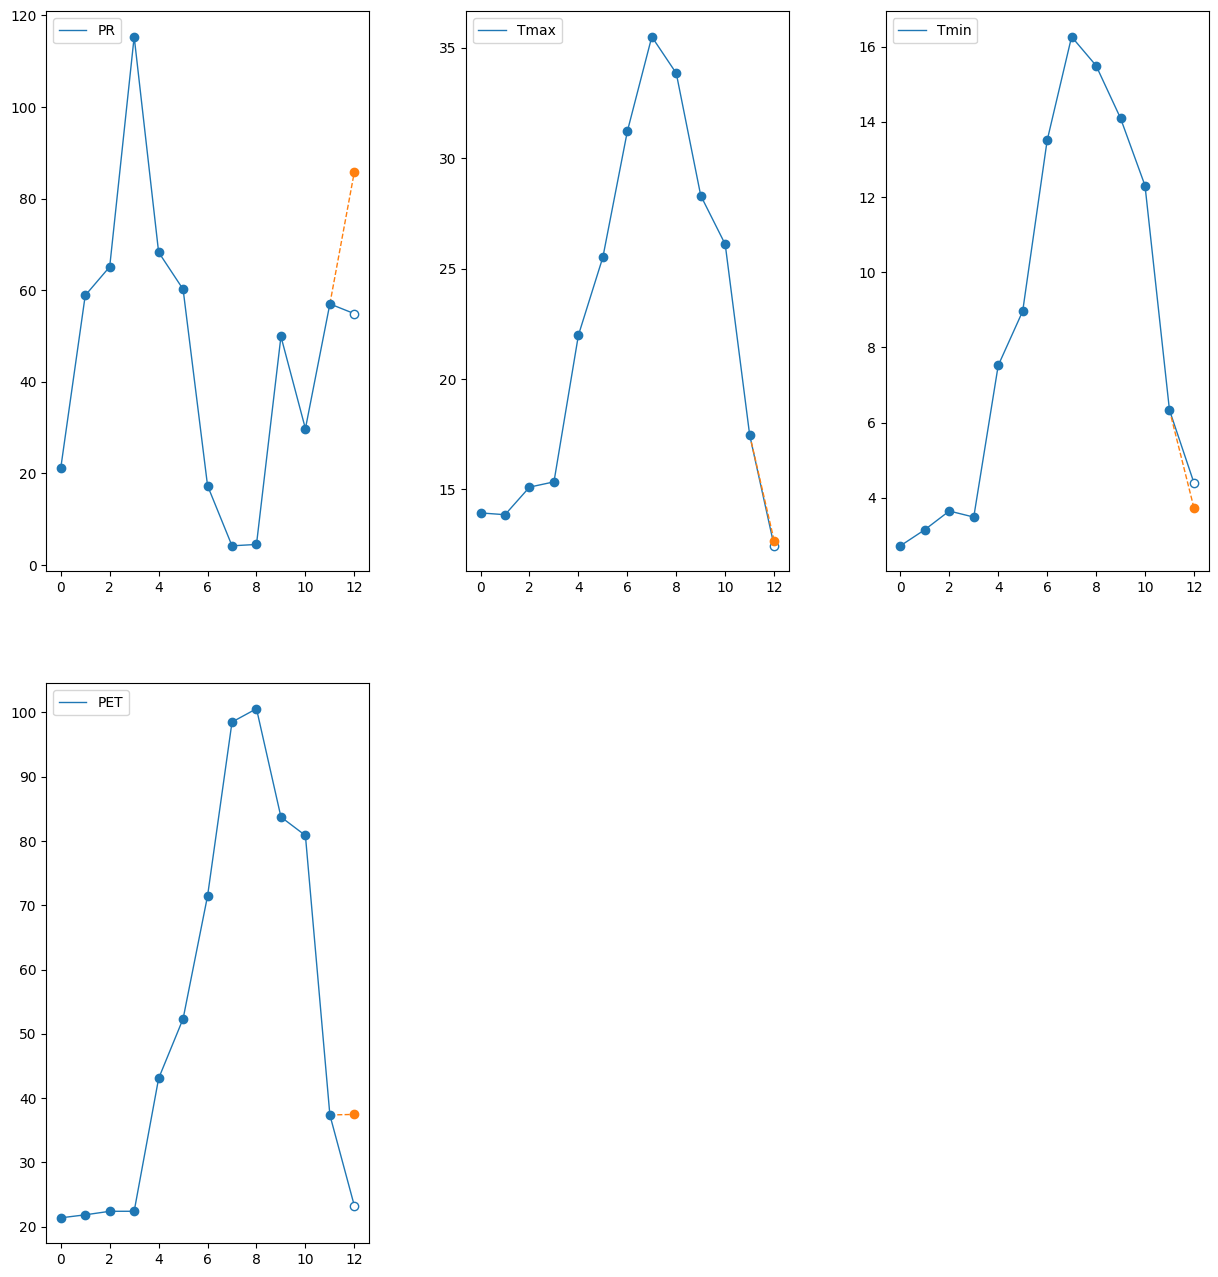

In [ ]:
def denormalize(mean, std, seq):
    nseq = seq.copy()
    for i, s in enumerate(nseq):
        s = s * std + mean
        nseq[i] = s
    return nseq

sequence_true = denormalize(mean, std, sequence_true)
pred = denormalize(mean, std, pred)
print(sequence_true)
print('=======================================================================================')
print(sequence_true.shape)
feat = 4

fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, height=8, save_as='03-prediction')

[[ 895.99864356  147.86226605   25.13993516  799.67438779]
 [2394.35950039  147.139806     27.60419926  815.87573503]
 [2643.09393362  158.32647702   30.4575577   834.96720537]
 [4640.98795858  160.46196927   29.53114262  835.08537528]
 [2769.23111989  219.97437485   52.68596105 1553.35261826]
 [2447.70917023  251.63642724   60.97367032 1875.92412344]
 [ 742.12662931  302.69123387   87.05287234 2539.97591161]
 [ 219.6196527   341.0769811   102.90321669 3480.29834926]
 [ 231.62760418  326.25210093   98.49348092 3552.26183766]
 [2038.01886664  276.62198552   90.4608446  2966.91200816]
 [1236.94252999  256.86703799   80.16899071 2866.94105644]
 [2320.72876245  179.5117958    45.88916243 1355.81589035]
 [2235.81794819  134.51120438   34.77465196  864.97712486]]
(13, 4)


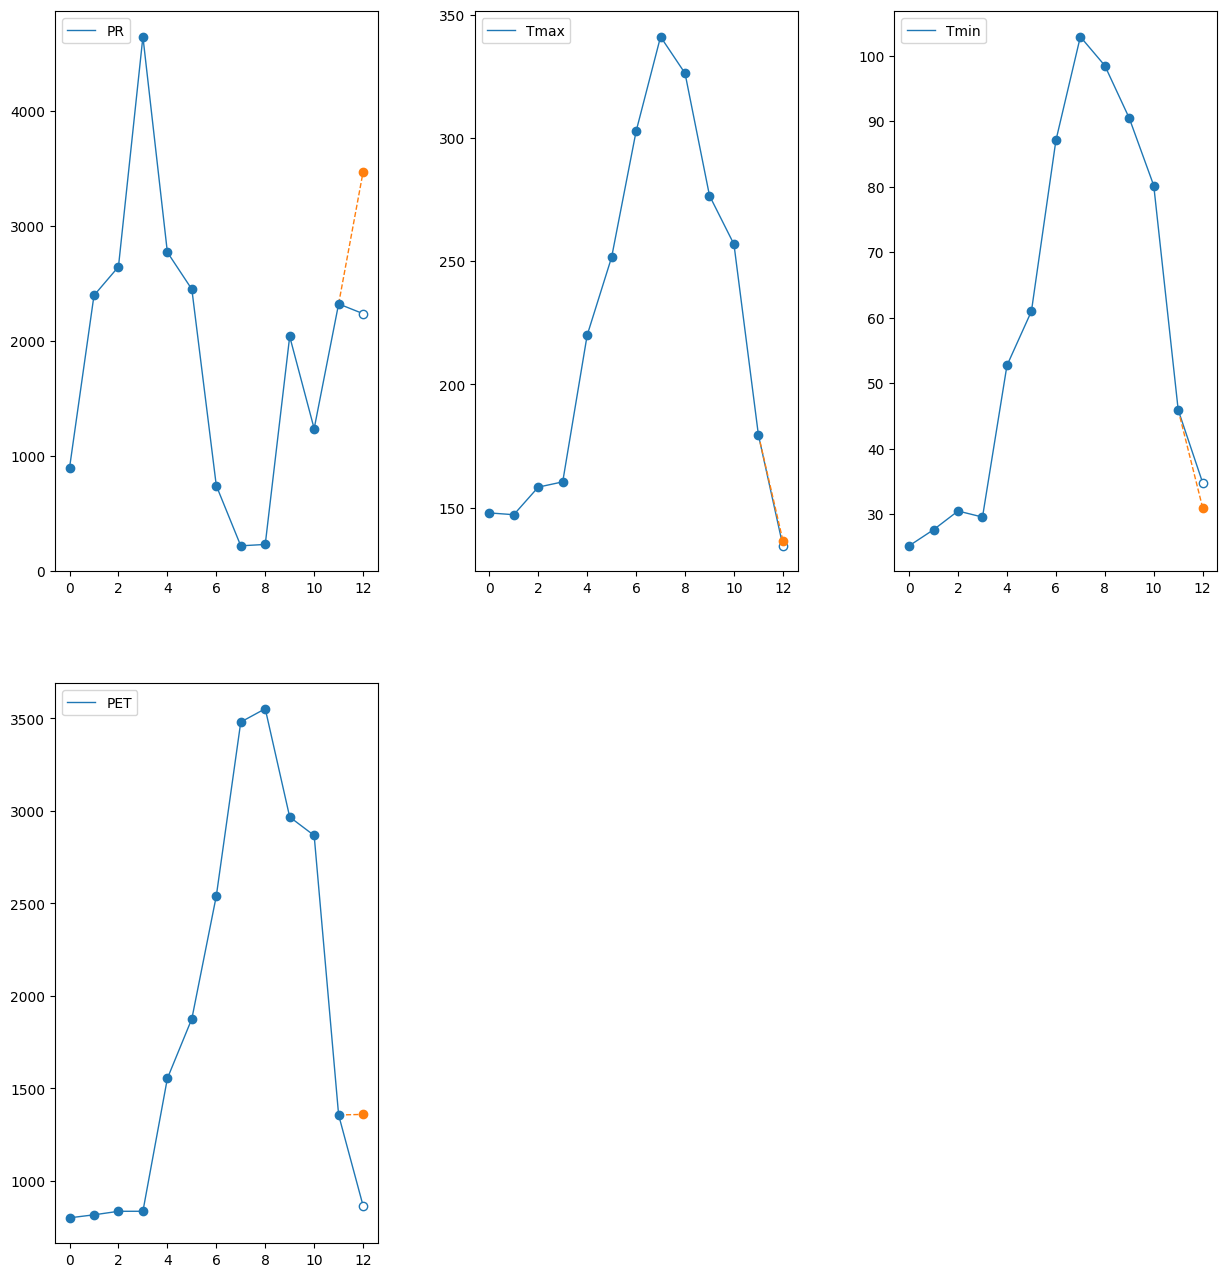

In [ ]:
sequence_true = denormalize(mean, std, sequence_true)
pred = denormalize(mean, std, pred)
print(sequence_true)
print('=======================================================================================')
print(sequence_true.shape)
feat = 4

fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, height=8, save_as='03-prediction')

In [ ]:
sequence_true

array([[ 895.99864356,  147.86226605,   25.13993516,  799.67438779],
       [2394.35950039,  147.139806  ,   27.60419926,  815.87573503],
       [2643.09393362,  158.32647702,   30.4575577 ,  834.96720537],
       [4640.98795858,  160.46196927,   29.53114262,  835.08537528],
       [2769.23111989,  219.97437485,   52.68596105, 1553.35261826],
       [2447.70917023,  251.63642724,   60.97367032, 1875.92412344],
       [ 742.12662931,  302.69123387,   87.05287234, 2539.97591161],
       [ 219.6196527 ,  341.0769811 ,  102.90321669, 3480.29834926],
       [ 231.62760418,  326.25210093,   98.49348092, 3552.26183766],
       [2038.01886664,  276.62198552,   90.4608446 , 2966.91200816],
       [1236.94252999,  256.86703799,   80.16899071, 2866.94105644],
       [2320.72876245,  179.5117958 ,   45.88916243, 1355.81589035],
       [2235.81794819,  134.51120438,   34.77465196,  864.97712486]])

In [ ]:
pred

array([[3466.5793  ,  136.66545 ,   30.942604, 1358.849   ]],
      dtype=float32)

1/1 [==============================] - 0s 89ms/step
true values:  [[-0.55776581 -0.28465175 -0.64349993 -0.62258103]
 [-0.39110417  0.26625145 -0.19278278 -0.21112484]
 [-0.95319154  0.81635046  0.7800706   0.42845718]
 [-1.26874218  1.36234452  1.09725371  1.12975973]
 [-1.33990568  1.55822975  1.41119816  1.72853212]
 [-0.44295384  0.98602163  1.18746828  1.35634255]
 [-0.11138545  0.21908056  0.49126791  0.63610913]
 [-0.13328636 -0.44650912 -0.20186228 -0.21387062]
 [ 1.2211811  -1.36564534 -1.10990494 -1.08475391]
 [ 2.70595533 -1.46826903 -1.305348   -1.24600538]
 [ 3.43104623 -1.5834442  -1.52461971 -1.40677289]
 [ 1.12156978 -0.99403954 -1.08687861 -1.05949623]
 [-0.8142134  -0.16111923 -0.69515007 -0.56918647]
 [-0.28728665  0.4401716   0.03635735 -0.00965997]
 [-1.05548296  0.8126296   0.57579142  0.33541834]
 [-1.20512368  1.48945387  1.2966281   1.41283147]
 [-0.62590226  1.37098652  1.46904482  1.62498923]
 [-0.02893333  0.72481732  0.9936352   0.98303866]]
predicted value

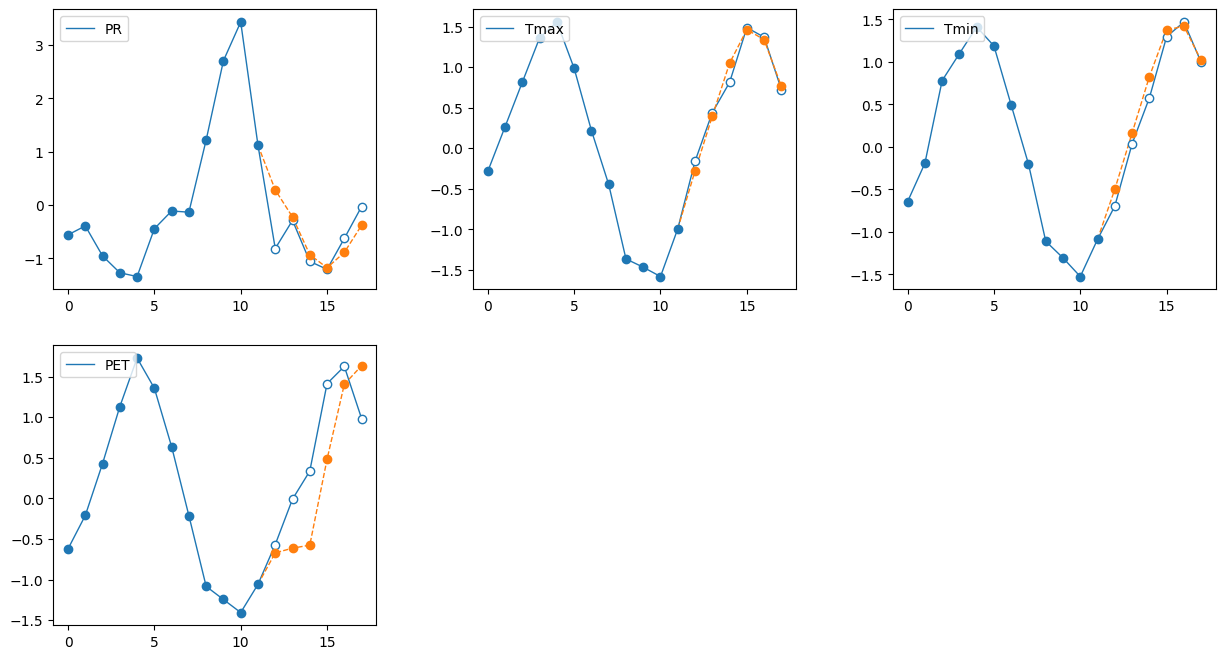

In [ ]:
iterations = 6 # 6 mois

s = random.randint(0, len(dataset_test)-sequence_len-iterations)
sequence_pred = dataset_test[s:s+sequence_len].copy()
sequence_true = dataset_test[s:s+sequence_len+iterations].copy()

sequence_pred = list(sequence_pred)
for i in range(iterations):
    sequence = sequence_pred[-sequence_len:]
    #print(sequence)
    pred = model.predict(np.array([sequence]))
    sequence_pred.append(pred[0])

pred = np.array(sequence_pred[-iterations:])
print('true values: ', sequence_true)
print('predicted values: ', pred)
fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-long-prediction-norm.png')

1/1 [==============================] - 0s 131ms/step
true values:  [[ 6.13635060e-01 -8.04827853e-01 -4.94933257e-01 -5.42016188e-01]
 [-8.07229039e-01 -1.01240378e+00 -1.17842234e+00 -9.97454103e-01]
 [ 1.39890500e-01 -1.02140586e+00 -1.10372715e+00 -9.84050769e-01]
 [ 2.97116471e-01 -8.82016433e-01 -1.01723798e+00 -9.68256443e-01]
 [ 1.55999281e+00 -8.55407531e-01 -1.04531888e+00 -9.68158681e-01]
 [ 3.76848262e-01 -1.13864317e-01 -3.43464888e-01 -3.73937971e-01]
 [ 1.73613027e-01  2.80654772e-01 -9.22531664e-02 -1.07075364e-01]
 [-9.04492119e-01  9.16813654e-01  6.98242860e-01  4.42293034e-01]
 [-1.23477075e+00  1.39511209e+00  1.17868832e+00  1.22021946e+00]
 [-1.22718047e+00  1.21038944e+00  1.04502324e+00  1.27975467e+00]
 [-8.53537564e-02  5.91982654e-01  8.01543127e-01  7.95496209e-01]
 [-5.91717125e-01  3.45829821e-01  4.89583060e-01  7.12790488e-01]
 [ 9.33482331e-02 -6.18040726e-01 -5.49485084e-01 -5.37359616e-01]
 [ 3.96757877e-02 -1.17876219e+00 -8.86380989e-01 -9.43429311e

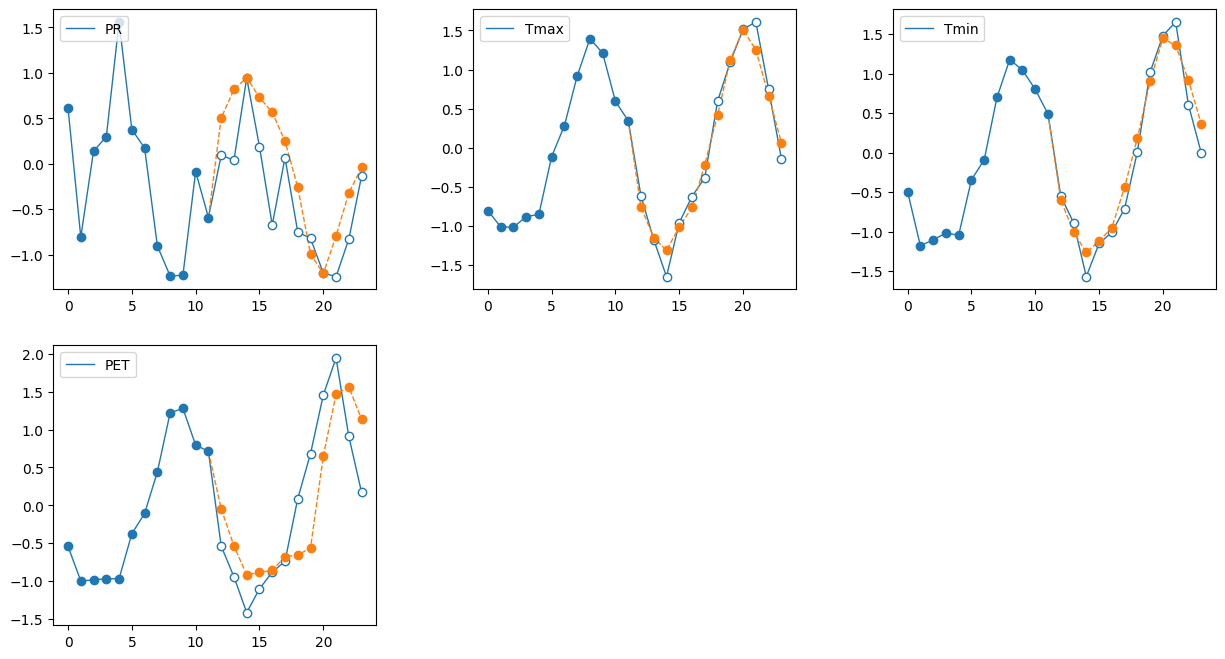

In [ ]:
iterations = 12 # 5 mois

s = random.randint(0, len(dataset_test)-sequence_len-iterations)
sequence_pred = dataset_test[s:s+sequence_len].copy()
sequence_true = dataset_test[s:s+sequence_len+iterations].copy()

sequence_pred = list(sequence_pred)
for i in range(iterations):
    sequence = sequence_pred[-sequence_len:]
    #print(sequence)
    pred = model.predict(np.array([sequence]))
    sequence_pred.append(pred[0])

pred = np.array(sequence_pred[-iterations:])
print('true values: ', sequence_true)
print('predicted values: ', pred)
fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-real-prediction-norm.png')

In [ ]:
dataset = []
for i in dataset_train:
	dataset.append(i)

dataset = np.array(dataset)

iterations = len(dataset_test) # 5 mois

s = random.randint(0, len(dataset)-sequence_len-iterations)
sequence_pred = dataset[s:s+sequence_len].copy()
sequence_true = dataset[s:s+sequence_len+iterations].copy()

sequence_pred = list(sequence_pred)
for i in range(iterations):
    sequence = sequence_pred[-sequence_len:]
    #print(sequence)
    pred = model.predict(np.array([sequence]))
    sequence_pred.append(pred[0])

pred = np.array(sequence_pred[-iterations:])
print('true values: ', sequence_true)
print('predicted values: ', pred)

1/1 [==============================] - 0s 101ms/step
true values:  [[-0.19113484  0.8654658   1.26987636  1.30630547]
 [ 0.30998147 -0.02073481  0.47722746  0.54665642]
 [ 0.04519941 -0.69989963 -0.51292375 -0.42475056]
 [-0.98825663 -1.42397881 -1.26322665 -1.09234767]
 [ 0.11698895 -1.27310397 -1.45810809 -1.17169419]
 [ 0.2248417  -1.12374397 -1.15832029 -1.07671869]
 [ 1.033765   -0.97819588 -0.85099906 -0.880669  ]
 [ 0.98241062 -0.55032109 -0.62376842 -0.6978692 ]
 [ 1.19981067  0.09161112 -0.06473389 -0.16861321]
 [-0.9043815   0.65300474  0.38486003  0.1748669 ]
 [-0.97546706  1.02926762  0.91753596  0.82999237]
 [-1.20199857  1.43904223  1.30168266  1.58304958]
 [-0.73486124  0.90899985  1.02497348  1.16065703]
 [-0.09947583  0.2842556   0.38624535  0.57734152]
 [ 0.50897279 -0.6318079  -0.25989613 -0.37971227]
 [ 2.20959332 -1.12582997 -0.86391627 -0.9092435 ]
 [-0.29002458 -1.34656093 -1.41205542 -1.26744859]
 [-0.43072493 -1.45666921 -1.31134528 -1.29969514]
 [ 0.25687722 -

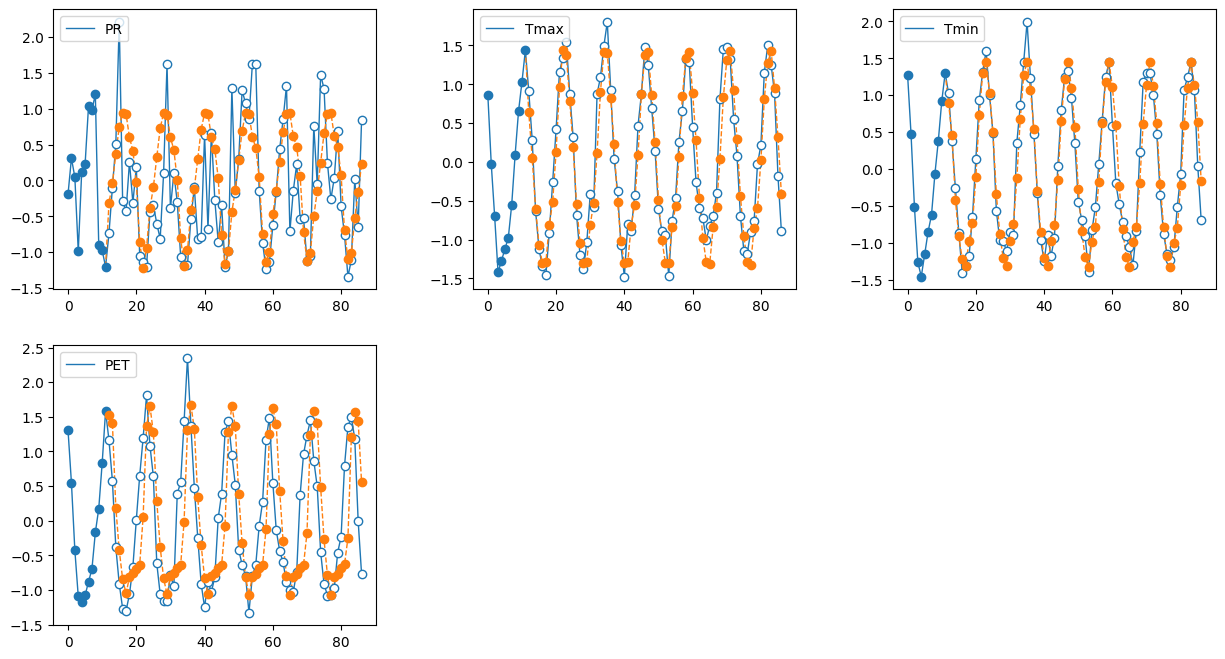

In [ ]:
fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-real-prediction-norm.png')

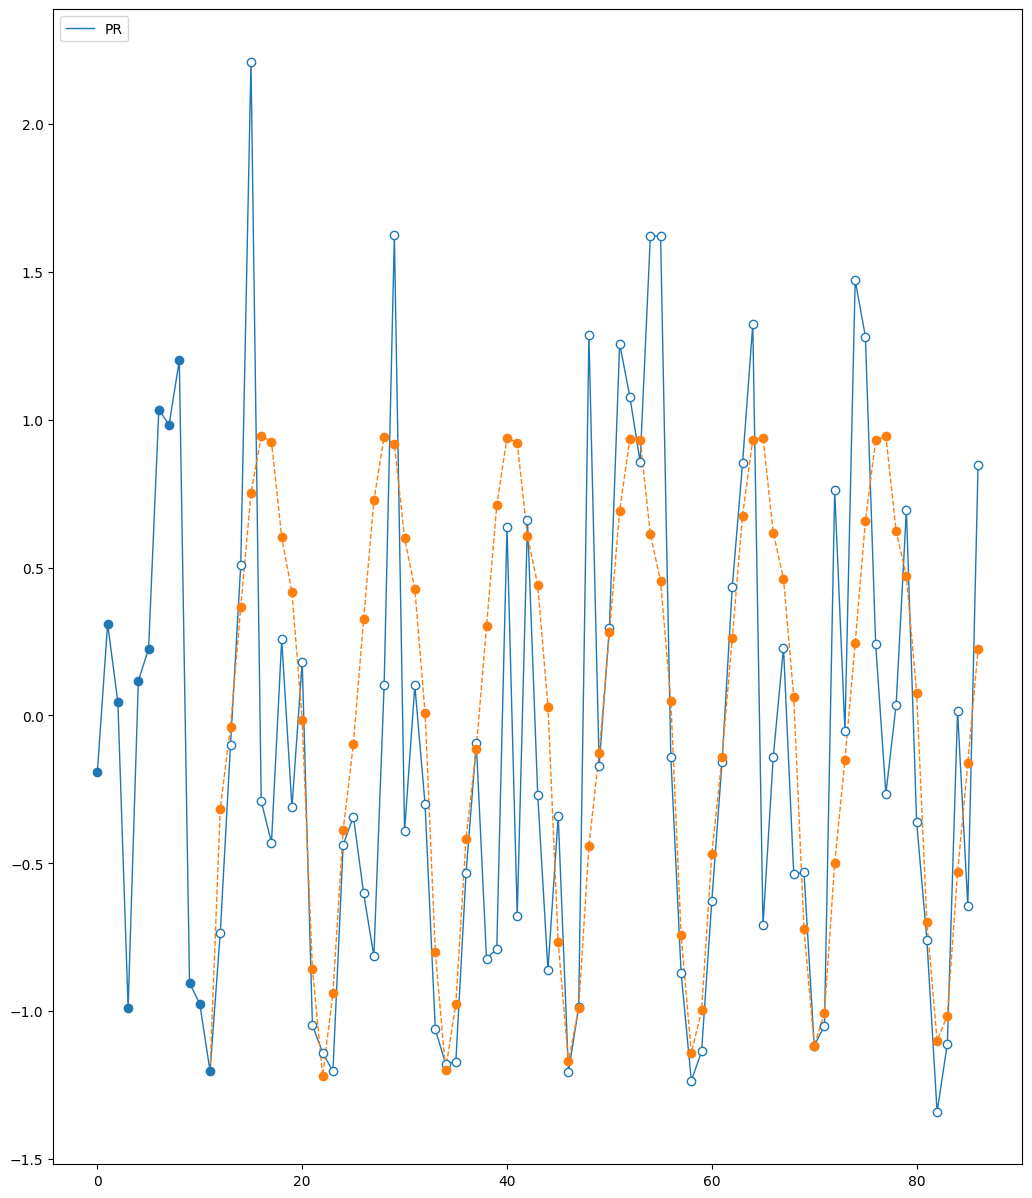

In [ ]:
fidle.scrawler.multivariate_serie(sequence_true[:,0:1], predictions=pred[:,0:1], labels=features[0:1], height=15, width=15, save_as='02-real-prediction-norm.png')

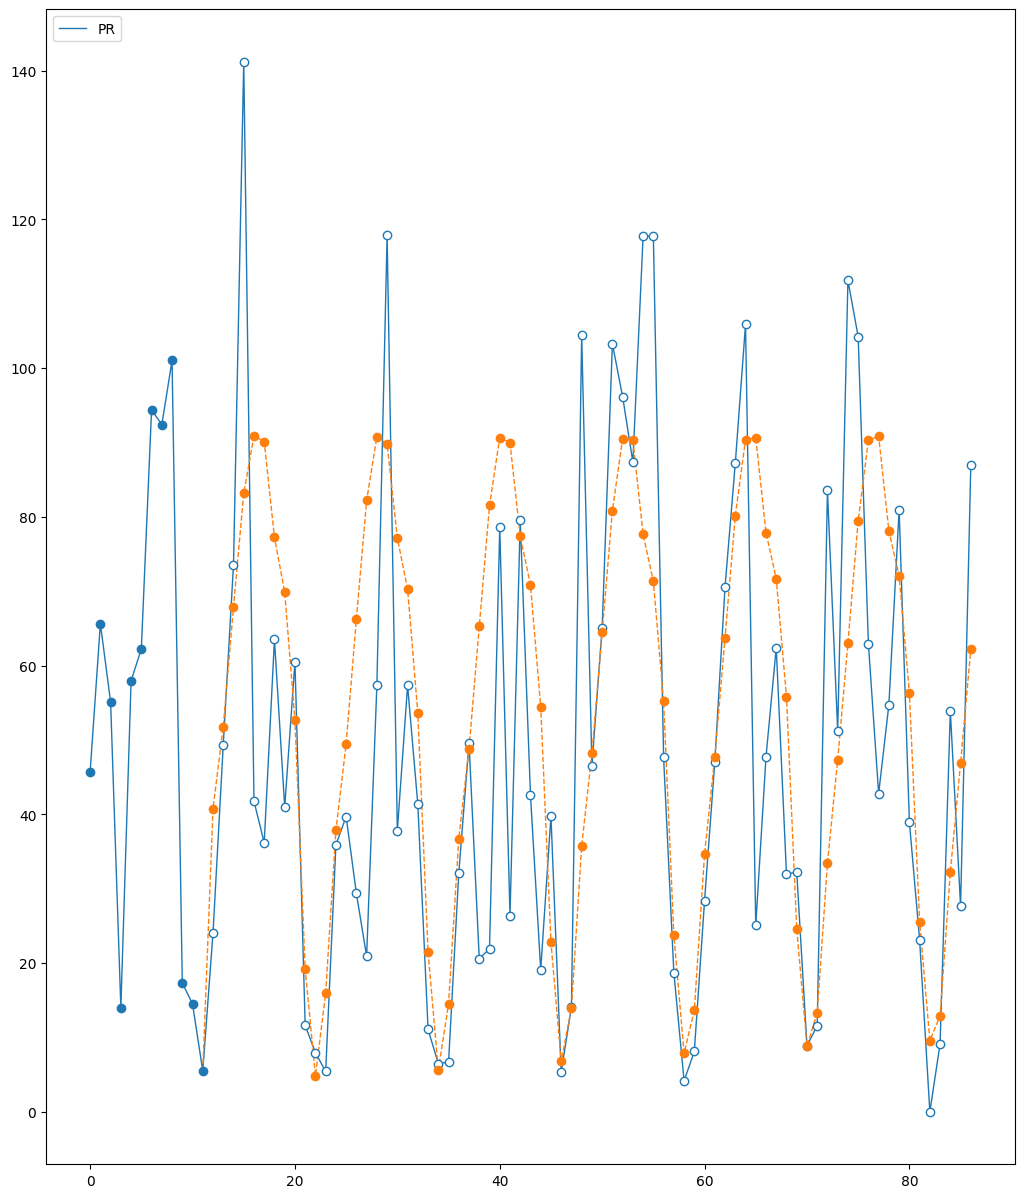

In [ ]:
pred = denormalize(mean, std, pred)
sequence_true = denormalize(mean, std, sequence_true)
fidle.scrawler.multivariate_serie(sequence_true[:,0:1], predictions=pred[:,0:1], labels=features[0:1], height=15, width=15, save_as='02-real-prediction-norm.png')

In [ ]:
dataset = []
for i in dataset_train:
	dataset.append(i)

dataset = np.array(dataset)

iterations = len(dataset_test) # 5 mois

#s = random.randint(0, len(dataset)-sequence_len-iterations)
s = 0
sequence_pred = dataset[s:s+sequence_len].copy()
sequence_true = dataset[s:s+sequence_len+iterations].copy()

sequence_pred = list(sequence_pred)
for i in range(iterations):
    sequence = sequence_pred[-sequence_len:]
    #print(sequence)
    pred = model.predict(np.array([sequence]))
    sequence_pred.append(pred[0])

pred = np.array(sequence_pred[-iterations:])
print('true values: ', sequence_true)
print('predicted values: ', pred)

1/1 [==============================] - 0s 94ms/step
true values:  [[-0.24899588 -1.21080959 -1.36544113 -1.19572101]
 [-0.24244899 -0.92325748 -1.21434583 -1.07898668]
 [ 0.29354887 -0.41106494 -0.72688148 -0.64544113]
 [ 0.98782362 -0.23479224 -0.75956765 -0.6205807 ]
 [-0.46742172  0.40992462 -0.055748   -0.08143997]
 [-0.75701357  0.66156272  0.70752828  0.26682498]
 [-1.08022236  1.44120273  1.50891969  1.34551109]
 [-1.02882021  1.41995782  1.71896482  1.76668397]
 [-0.71608544  0.88034923  1.08706971  1.15237219]
 [-0.17921768  0.08584979  0.31155016  0.34248571]
 [-0.07366539 -0.32409286 -0.24422699 -0.17818453]
 [ 0.02356752 -0.67932688 -0.4775231  -0.4524147 ]
 [ 2.90191959 -1.33611852 -1.0492502  -1.10521891]
 [-1.03920624 -0.56525768 -0.85121969 -0.81324033]
 [-0.01029329 -0.50432647 -0.80606962 -0.75360345]
 [ 0.51680442 -0.37804531 -0.59301048 -0.71094809]
 [ 0.79914542  0.1989159   0.19361039 -0.15648978]
 [-0.84873291  1.21187778  1.18456659  0.78129147]
 [-1.17797822  1

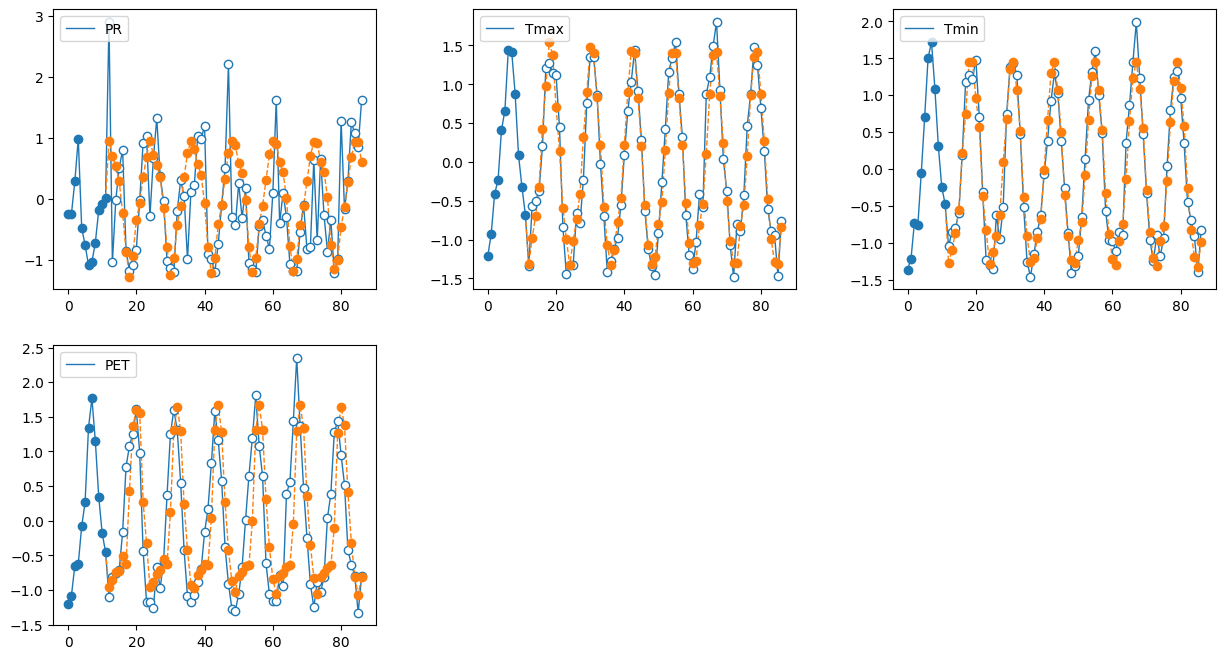

In [ ]:
fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-real-prediction-norm.png')

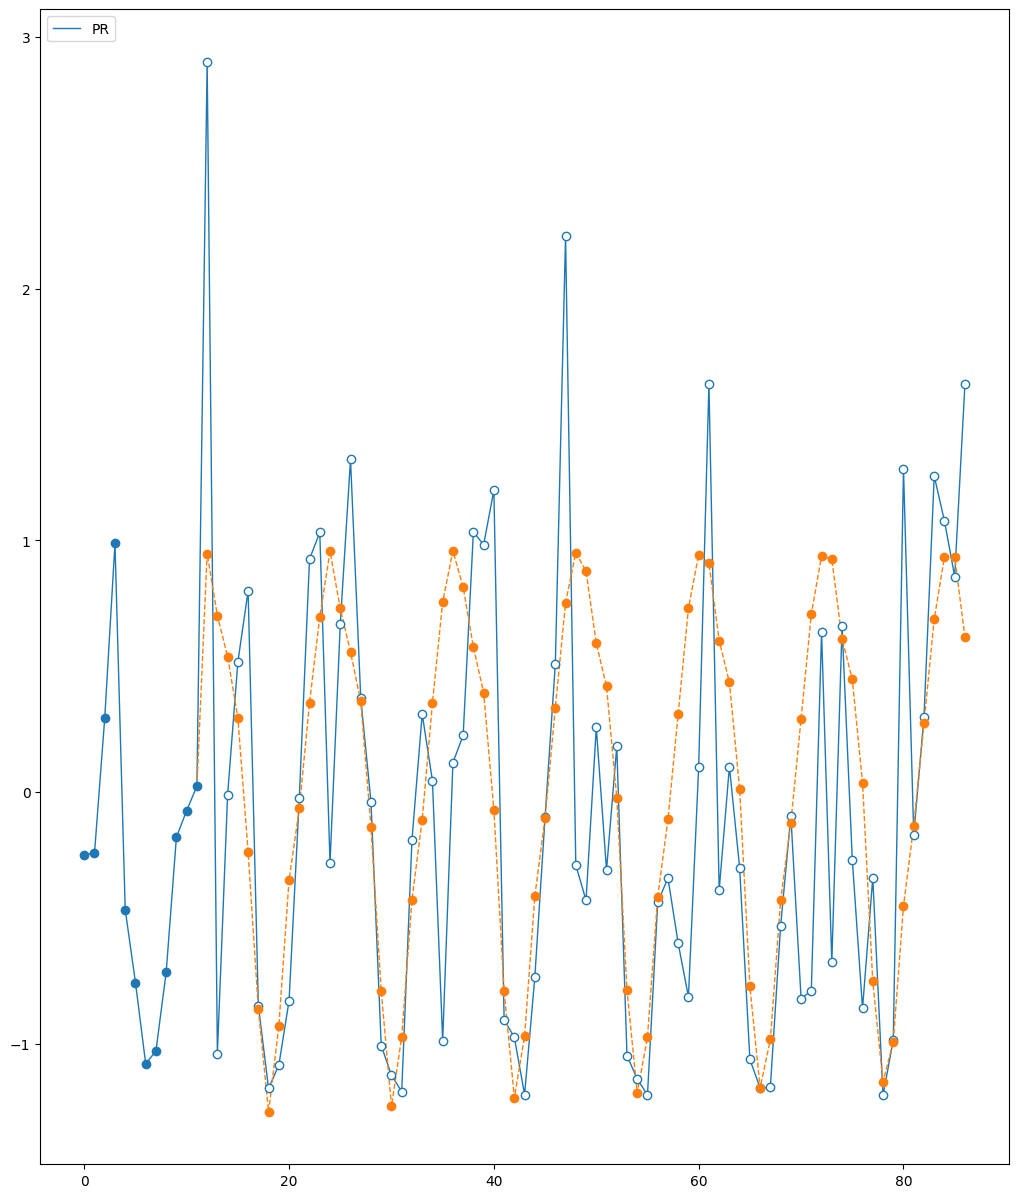

In [ ]:
fidle.scrawler.multivariate_serie(sequence_true[:,0:1], predictions=pred[:,0:1], labels=features[0:1], height=15, width=15, save_as='02-real-prediction-norm.png')

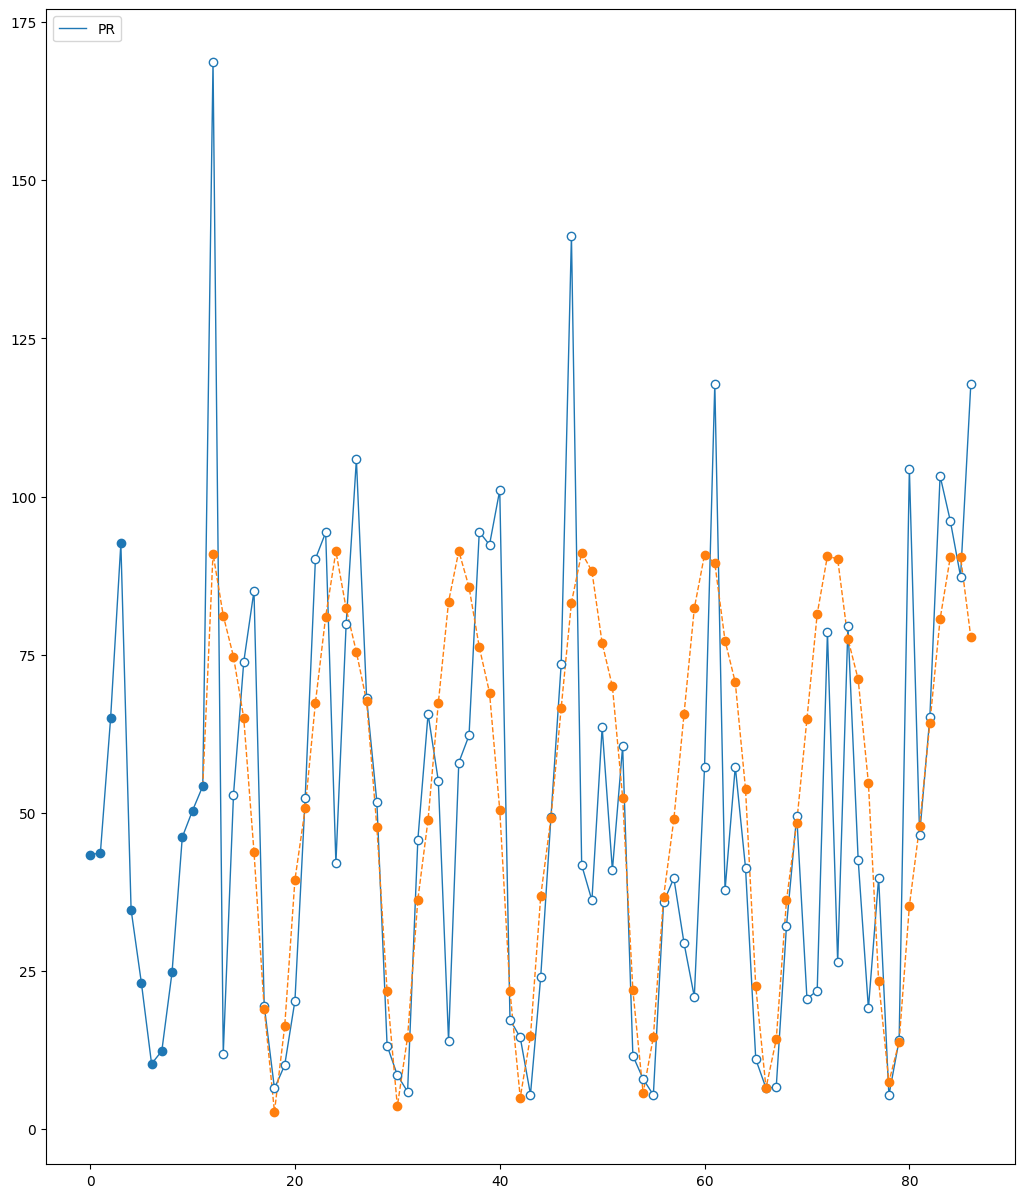

In [ ]:
pred = denormalize(mean, std, pred)
sequence_true = denormalize(mean, std, sequence_true)
fidle.scrawler.multivariate_serie(sequence_true[:,0:1], predictions=pred[:,0:1], labels=features[0:1], height=15, width=15, save_as='02-real-prediction-norm.png')

In [ ]:
features = ['PR', 'Tmax', 'Tmin', 'PET']
features_len = len(features)
#dates = df['Date']

#scale = 1
train_prop = .8
sequence_len = 12 # 12 mois
learning_rate = 0.001
batch_size = 98

#df = df[:int(scale * len(df))]
df = df[:len(df)]
train_len = int(train_prop * len(df))

dataset_train = df.loc[ :train_len-1, features]
dataset_test = df.loc[train_len:, features]
#print("=====Train Dataset Example=========")
#display(dataset_train.head(5))

#df.drop('Date', axis = 1, inplace = True)

#df.columns

mean = dataset_train.mean()
print('Moyenne:\n',mean)
std = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test = (dataset_test - mean) / std
#display(dataset_train.describe().style.format('{0:.2f}'))

dataset_train = dataset_train.to_numpy()
dataset_test = dataset_test.to_numpy()

print('Dataset: ', df.shape)
print('Train dataset: ', dataset_train.shape)
print('Test dataset: ', dataset_test.shape)

from keras.preprocessing.sequence import TimeseriesGenerator

train_generator = TimeseriesGenerator(dataset_train, dataset_train, length = sequence_len, batch_size = batch_size)
test_generator = TimeseriesGenerator(dataset_test, dataset_test, length = sequence_len, batch_size = batch_size)

x, y = train_generator[0]
x_val, y_val = test_generator[0]
print(f'nombre de batches disponibles: ', len(train_generator))
print('train batch x shape: ', x.shape)
print('train batch y shape: ', y.shape)

print('What a train batch looks like (x):')
print(x[0])
print('What a train batch looks like (y):')
print(y[0])
print('=======================================================================')
print('validation batch x shape: ', x_val.shape)
print('validation batch y shape: ', y_val.shape)
print('What a validation batch looks like (x):')
print(x_val[0])
print('What a validation batch looks like (y):')
print(y_val[0])

Moyenne:
 PR      53.294211
Tmax    23.006721
Tmin     9.492785
PET     56.066860
dtype: float64
Dataset:  (372, 5)
Train dataset:  (297, 4)
Test dataset:  (75, 4)
nombre de batches disponibles:  3
train batch x shape:  (98, 12, 4)
train batch y shape:  (98, 4)
What a train batch looks like (x):
[[-0.24899588 -1.21080959 -1.36544113 -1.19572101]
 [-0.24244899 -0.92325748 -1.21434583 -1.07898668]
 [ 0.29354887 -0.41106494 -0.72688148 -0.64544113]
 [ 0.98782362 -0.23479224 -0.75956765 -0.6205807 ]
 [-0.46742172  0.40992462 -0.055748   -0.08143997]
 [-0.75701357  0.66156272  0.70752828  0.26682498]
 [-1.08022236  1.44120273  1.50891969  1.34551109]
 [-1.02882021  1.41995782  1.71896482  1.76668397]
 [-0.71608544  0.88034923  1.08706971  1.15237219]
 [-0.17921768  0.08584979  0.31155016  0.34248571]
 [-0.07366539 -0.32409286 -0.24422699 -0.17818453]
 [ 0.02356752 -0.67932688 -0.4775231  -0.4524147 ]]
What a train batch looks like (y):
[ 2.90191959 -1.33611852 -1.0492502  -1.10521891]
valid

In [ ]:
optimized_model2 = tf.keras.models.load_model('optimized_model2.h5', custom_objects={"val_mse": val_mse })
optimized_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 256)           267264    
                                                                 
 dropout (Dropout)           (None, 12, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 12, 256)           394240    
                                                                 
 dropout_2 (Dropout)         (None, 12, 256)           0         
                                                                 
 flatten (Flatten)           (None, 3072)              0

(13, 4)
1/1 [==============================] - 3s 3s/step


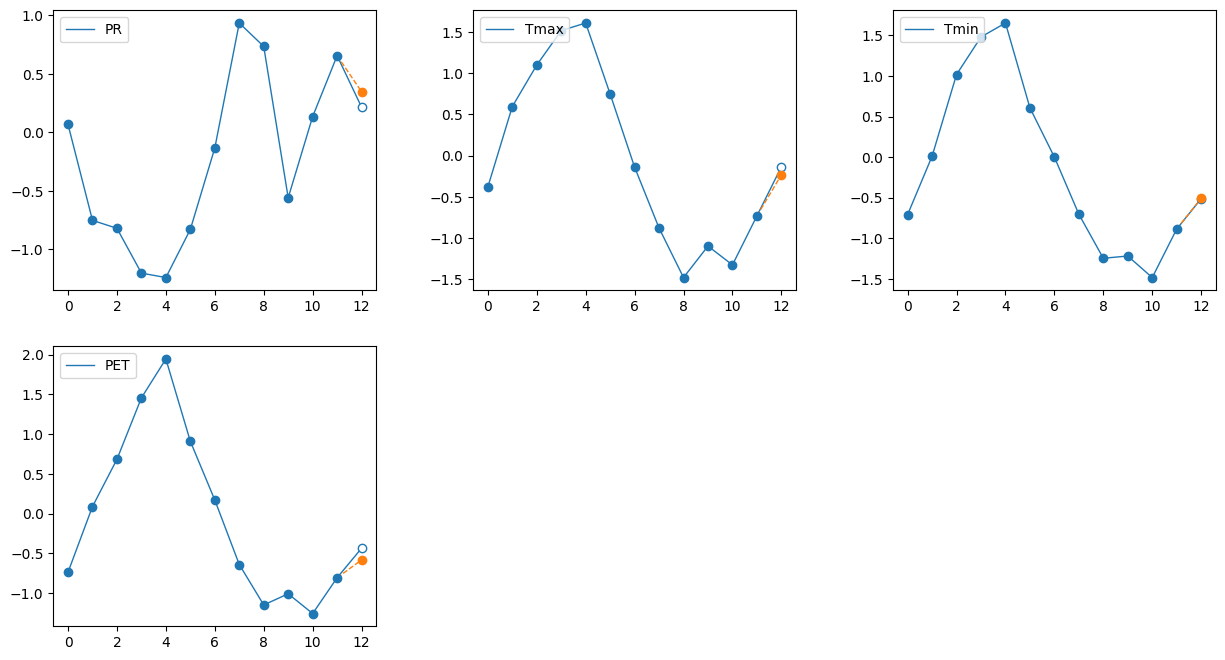

In [ ]:
s = random.randint(0, len(dataset_test) - sequence_len)

sequence = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

print(sequence_true.shape)

pred = optimized_model2.predict(np.array([sequence]))

fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm.png')

(13, 4)
1/1 [==============================] - 0s 108ms/step


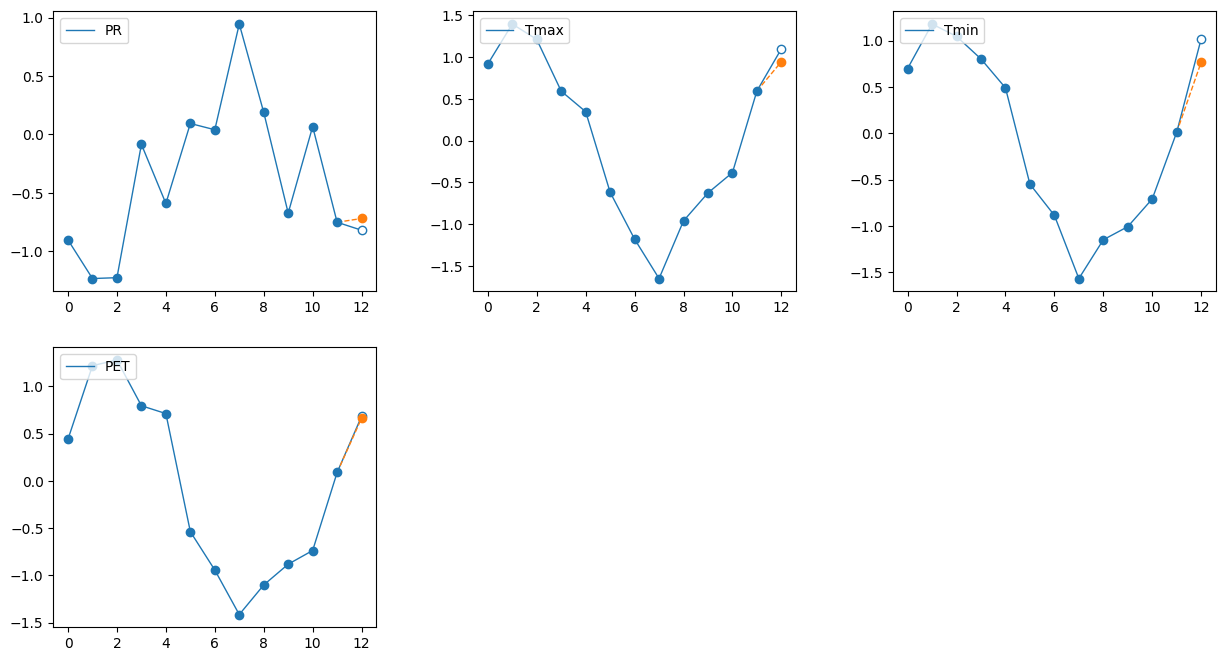

In [ ]:
s = random.randint(0, len(dataset_test) - sequence_len)

sequence = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

print(sequence_true.shape)

pred = optimized_model2.predict(np.array([sequence]))

fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm.png')

[[ 17.3184      31.22        13.50333333  71.44412994]
 [  4.1817      35.50483871  16.26290323  98.49041748]
 [  4.4836      33.85        15.49516129 100.56028748]
 [ 49.8993      28.31        14.09666667  83.72399902]
 [ 29.7589      26.10483871  12.30483871  80.84855652]
 [ 57.0071      17.47         6.33666667  37.3843956 ]
 [ 54.8723      12.44677419   4.4016129   23.2665081 ]
 [ 90.8986       8.22096774   0.48548387   6.88243294]
 [ 60.7937      14.40357143   2.88928571  17.7625885 ]
 [ 26.4865      17.4016129    3.7016129   25.42063141]
 [ 55.9447      19.58         5.42        30.4467659 ]
 [ 23.3584      28.32741935   9.55322581  59.16143036]
 [ 20.6517      32.84333333  15.34333333  79.82163239]]
(13, 4)


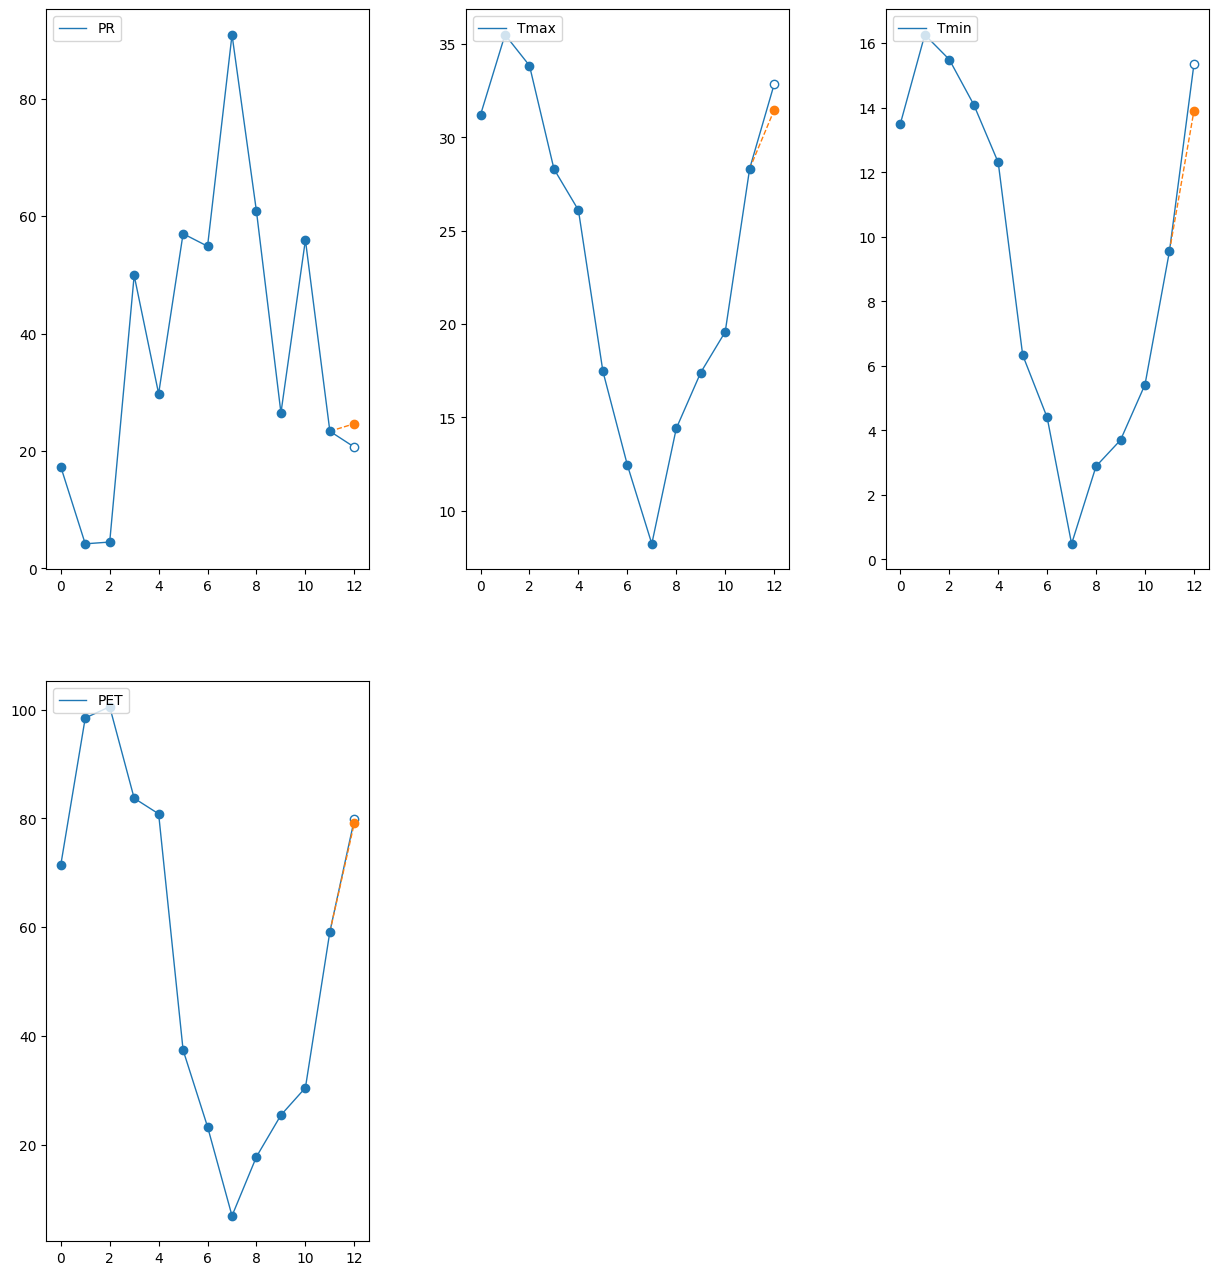

In [ ]:
def denormalize(mean, std, seq):
    nseq = seq.copy()
    for i, s in enumerate(nseq):
        s = s * std + mean
        nseq[i] = s
    return nseq

sequence_true = denormalize(mean, std, sequence_true)
pred = denormalize(mean, std, pred)
print(sequence_true)
print('=======================================================================================')
print(sequence_true.shape)
feat = 4

fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, height=8, save_as='03-prediction')

[[ 742.12662931  302.69123387   87.05287234 2539.97591161]
 [ 219.6196527   341.0769811   102.90321669 3480.29834926]
 [ 231.62760418  326.25210093   98.49348092 3552.26183766]
 [2038.01886664  276.62198552   90.4608446  2966.91200816]
 [1236.94252999  256.86703799   80.16899071 2866.94105644]
 [2320.72876245  179.5117958    45.88916243 1355.81589035]
 [2235.81794819  134.51120438   34.77465196  864.97712486]
 [3668.74958943   96.6542979    12.2812939   295.34946425]
 [2471.33925958  152.04118138   26.08818716  673.62150575]
 [1106.78413174  178.89914968   30.75401052  939.86986108]
 [2278.47222832  198.41424048   40.62403675 1114.61425179]
 [ 982.36520815  276.77803689   64.3643495  2112.94140645]
 [ 874.70730064  317.23387298   97.62141553 2831.23782719]]
(13, 4)


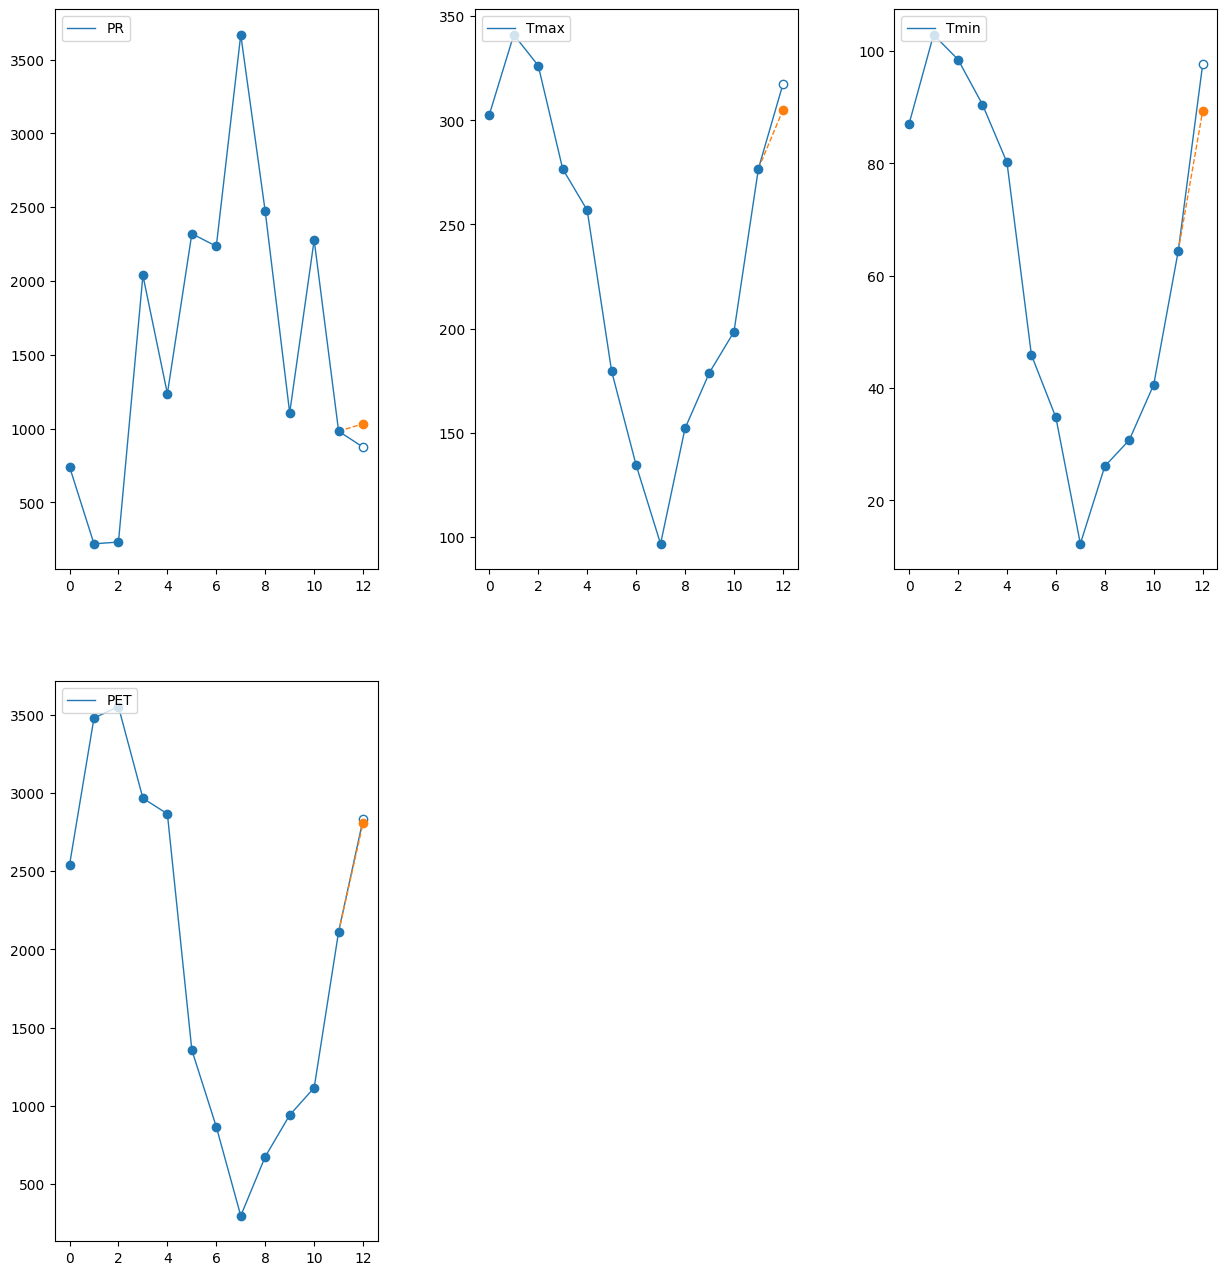

In [ ]:
sequence_true = denormalize(mean, std, sequence_true)
pred = denormalize(mean, std, pred)
print(sequence_true)
print('=======================================================================================')
print(sequence_true.shape)
feat = 4

fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, height=8, save_as='03-prediction')

In [ ]:
sequence_true

array([[ 742.12662931,  302.69123387,   87.05287234, 2539.97591161],
       [ 219.6196527 ,  341.0769811 ,  102.90321669, 3480.29834926],
       [ 231.62760418,  326.25210093,   98.49348092, 3552.26183766],
       [2038.01886664,  276.62198552,   90.4608446 , 2966.91200816],
       [1236.94252999,  256.86703799,   80.16899071, 2866.94105644],
       [2320.72876245,  179.5117958 ,   45.88916243, 1355.81589035],
       [2235.81794819,  134.51120438,   34.77465196,  864.97712486],
       [3668.74958943,   96.6542979 ,   12.2812939 ,  295.34946425],
       [2471.33925958,  152.04118138,   26.08818716,  673.62150575],
       [1106.78413174,  178.89914968,   30.75401052,  939.86986108],
       [2278.47222832,  198.41424048,   40.62403675, 1114.61425179],
       [ 982.36520815,  276.77803689,   64.3643495 , 2112.94140645],
       [ 874.70730064,  317.23387298,   97.62141553, 2831.23782719]])

In [ ]:
pred

array([[1033.3828  ,  304.85767 ,   89.328575, 2808.4946  ]],
      dtype=float32)

1/1 [==============================] - 0s 107ms/step
true values:  [[-0.32266853  0.62417409  0.7563516   1.14776851]
 [ 0.63298912 -0.92129074 -0.54774407 -0.62669393]
 [ 0.40589444 -1.33071727 -1.3115258  -1.15224611]
 [ 1.65642873 -1.20684867 -1.1896547  -1.07373849]
 [ 0.54990595 -0.95116393 -1.09744906 -1.03670531]
 [ 2.2373095  -1.11358714 -1.08744023 -1.06452646]
 [-0.55776581 -0.28465175 -0.64349993 -0.62258103]
 [-0.39110417  0.26625145 -0.19278278 -0.21112484]
 [-0.95319154  0.81635046  0.7800706   0.42845718]
 [-1.26874218  1.36234452  1.09725371  1.12975973]
 [-1.33990568  1.55822975  1.41119816  1.72853212]
 [-0.44295384  0.98602163  1.18746828  1.35634255]
 [-0.11138545  0.21908056  0.49126791  0.63610913]
 [-0.13328636 -0.44650912 -0.20186228 -0.21387062]
 [ 1.2211811  -1.36564534 -1.10990494 -1.08475391]
 [ 2.70595533 -1.46826903 -1.305348   -1.24600538]
 [ 3.43104623 -1.5834442  -1.52461971 -1.40677289]
 [ 1.12156978 -0.99403954 -1.08687861 -1.05949623]]
predicted valu

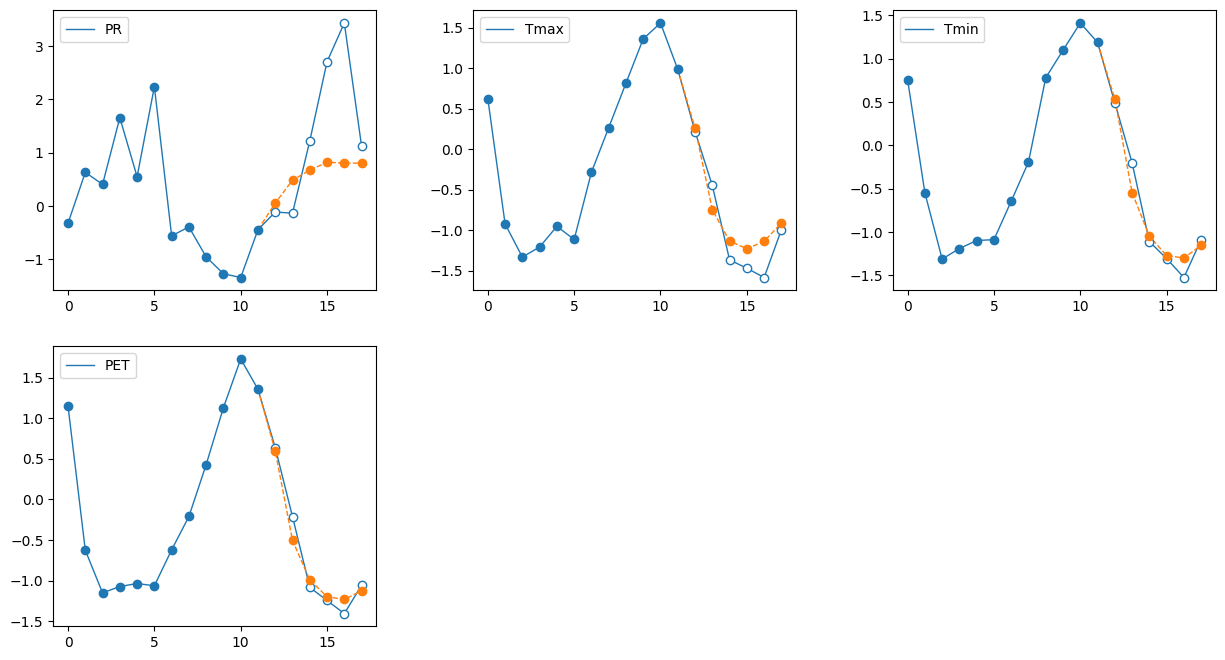

In [ ]:
iterations = 6 # 6 mois

s = random.randint(0, len(dataset_test)-sequence_len-iterations)
sequence_pred = dataset_test[s:s+sequence_len].copy()
sequence_true = dataset_test[s:s+sequence_len+iterations].copy()

sequence_pred = list(sequence_pred)
for i in range(iterations):
    sequence = sequence_pred[-sequence_len:]
    #print(sequence)
    pred = optimized_model2.predict(np.array([sequence]))
    sequence_pred.append(pred[0])

pred = np.array(sequence_pred[-iterations:])
print('true values: ', sequence_true)
print('predicted values: ', pred)
fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-long-prediction-norm.png')

1/1 [==============================] - 0s 107ms/step
true values:  [[-8.20687377e-01  1.09801949e+00  1.01858976e+00  6.83253295e-01]
 [-1.20343668e+00  1.51646011e+00  1.48140041e+00  1.45628198e+00]
 [-1.24126735e+00  1.60864139e+00  1.65381713e+00  1.94462054e+00]
 [-8.29879173e-01  7.47142479e-01  6.07710042e-01  9.09142458e-01]
 [-1.34251798e-01 -1.40282417e-01  4.13800200e-04  1.71079978e-01]
 [ 9.33517605e-01 -8.79617121e-01 -7.03855146e-01 -6.39888684e-01]
 [ 7.33392396e-01 -1.48051186e+00 -1.24693973e+00 -1.14864040e+00]
 [-5.59958162e-01 -1.09846365e+00 -1.21942045e+00 -1.00803820e+00]
 [ 1.34095344e-01 -1.32710358e+00 -1.48482506e+00 -1.25671815e+00]
 [ 6.54314289e-01 -7.32619180e-01 -8.86942607e-01 -8.06288275e-01]
 [ 2.14299798e-01 -1.36933644e-01 -5.12343415e-01 -4.34834389e-01]
 [ 3.60486060e-01  6.24443903e-02  9.30807668e-02 -1.82180361e-01]
 [-8.46316799e-01  7.22956895e-01  5.46774491e-01  3.18703183e-01]
 [-1.17729939e+00  1.68677943e+00  1.55890369e+00  1.63287665e

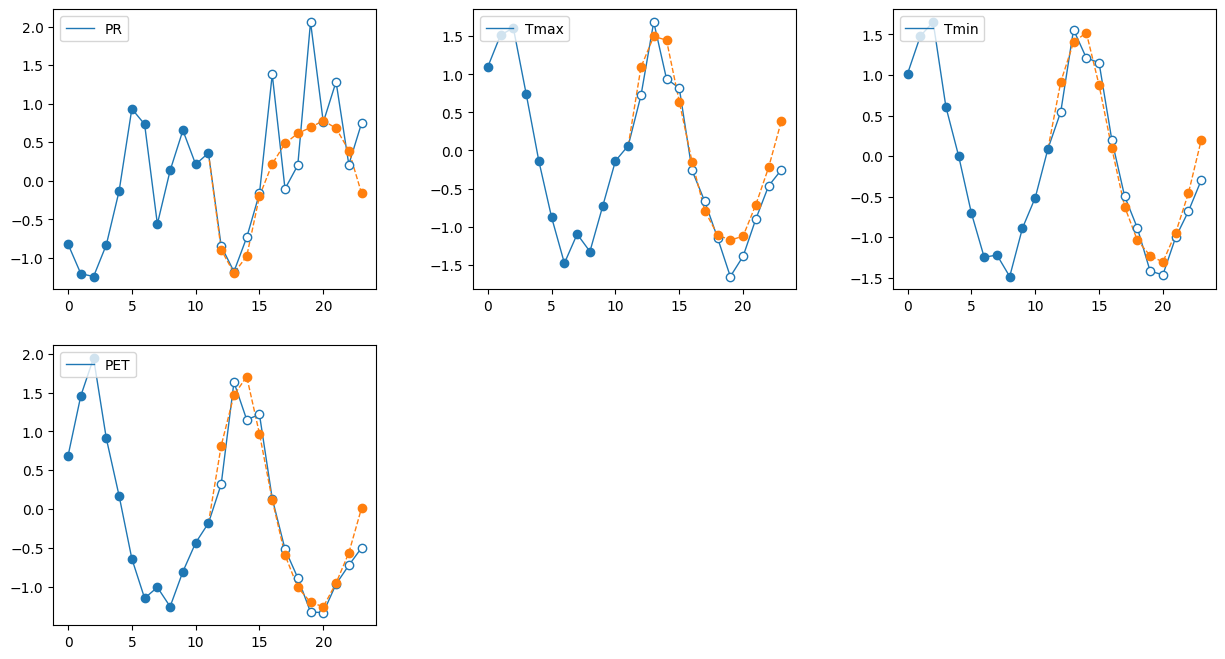

In [ ]:
iterations = 12 # 5 mois

s = random.randint(0, len(dataset_test)-sequence_len-iterations)
sequence_pred = dataset_test[s:s+sequence_len].copy()
sequence_true = dataset_test[s:s+sequence_len+iterations].copy()

sequence_pred = list(sequence_pred)
for i in range(iterations):
    sequence = sequence_pred[-sequence_len:]
    #print(sequence)
    pred = optimized_model2.predict(np.array([sequence]))
    sequence_pred.append(pred[0])

pred = np.array(sequence_pred[-iterations:])
print('true values: ', sequence_true)
print('predicted values: ', pred)
fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-real-prediction-norm.png')

In [ ]:
dataset = []
for i in dataset_train:
	dataset.append(i)

dataset = np.array(dataset)

iterations = len(dataset_test) # 5 mois

s = random.randint(0, len(dataset)-sequence_len-iterations)
sequence_pred = dataset[s:s+sequence_len].copy()
sequence_true = dataset[s:s+sequence_len+iterations].copy()

sequence_pred = list(sequence_pred)
for i in range(iterations):
    sequence = sequence_pred[-sequence_len:]
    #print(sequence)
    pred = optimized_model2.predict(np.array([sequence]))
    sequence_pred.append(pred[0])

pred = np.array(sequence_pred[-iterations:])
print('true values: ', sequence_true)
print('predicted values: ', pred)

1/1 [==============================] - 0s 91ms/step
true values:  [[ 4.01303576e+00 -1.32171520e+00 -1.05037344e+00 -1.06393440e+00]
 [ 5.76857820e-01 -1.42829980e+00 -1.17786072e+00 -1.16179488e+00]
 [-5.04141132e-01 -9.06651086e-01 -1.05205829e+00 -1.00657946e+00]
 [ 9.41105363e-01 -6.69604631e-01 -8.21233303e-01 -7.81660287e-01]
 [ 4.36335976e-01 -5.19810045e-01 -6.42339256e-01 -7.37495709e-01]
 [ 4.39413317e-01 -1.11475766e-01 -2.10754560e-01 -4.05279531e-01]
 [-3.59028419e-01  7.93281132e-01  7.04626584e-01  3.84142063e-01]
 [-1.33990568e+00  1.37602768e+00  1.31572311e+00  1.27846786e+00]
 [-9.22531270e-01  1.61044180e+00  1.66729596e+00  1.93082330e+00]
 [-2.13593892e-01  6.51516400e-01  1.04470499e+00  9.83188535e-01]
 [-4.21158523e-01  6.56581570e-01  7.80501173e-01  1.21405378e+00]
 [ 1.72108808e+00 -1.04705578e+00 -5.47744068e-01 -7.49398934e-01]
 [ 2.62253777e+00 -1.33611852e+00 -9.08284090e-01 -1.00250189e+00]
 [ 1.90427778e-01 -1.64723035e+00 -1.51707798e+00 -1.40508106e+

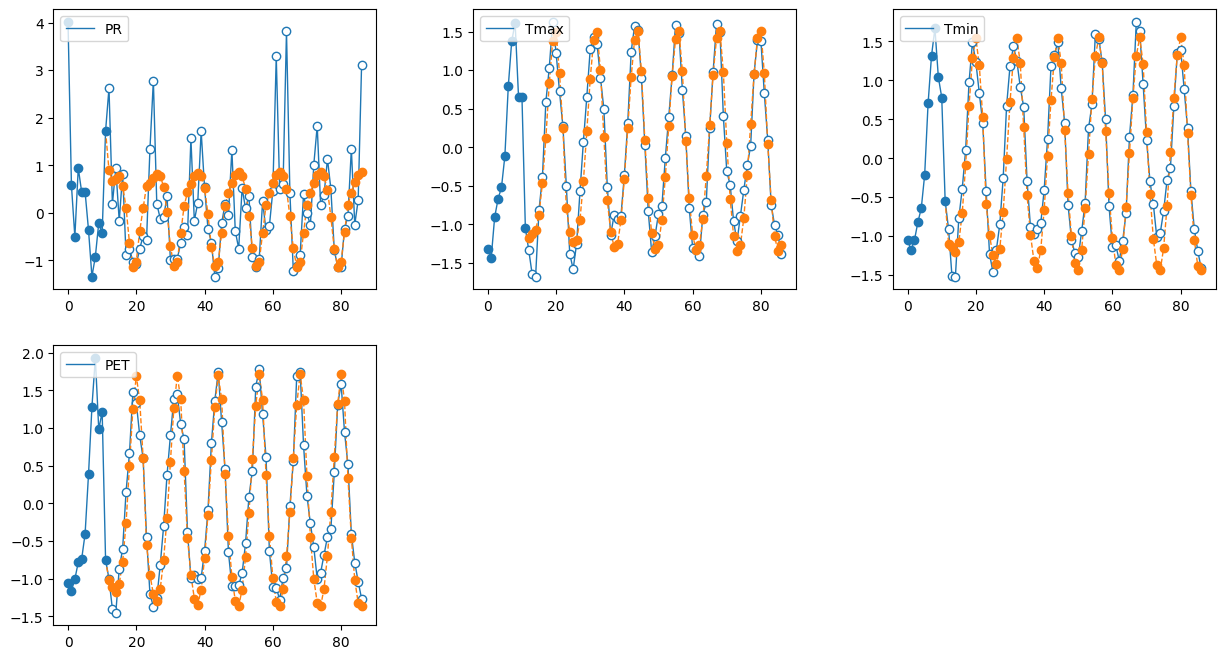

In [ ]:
fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-real-prediction-norm.png')

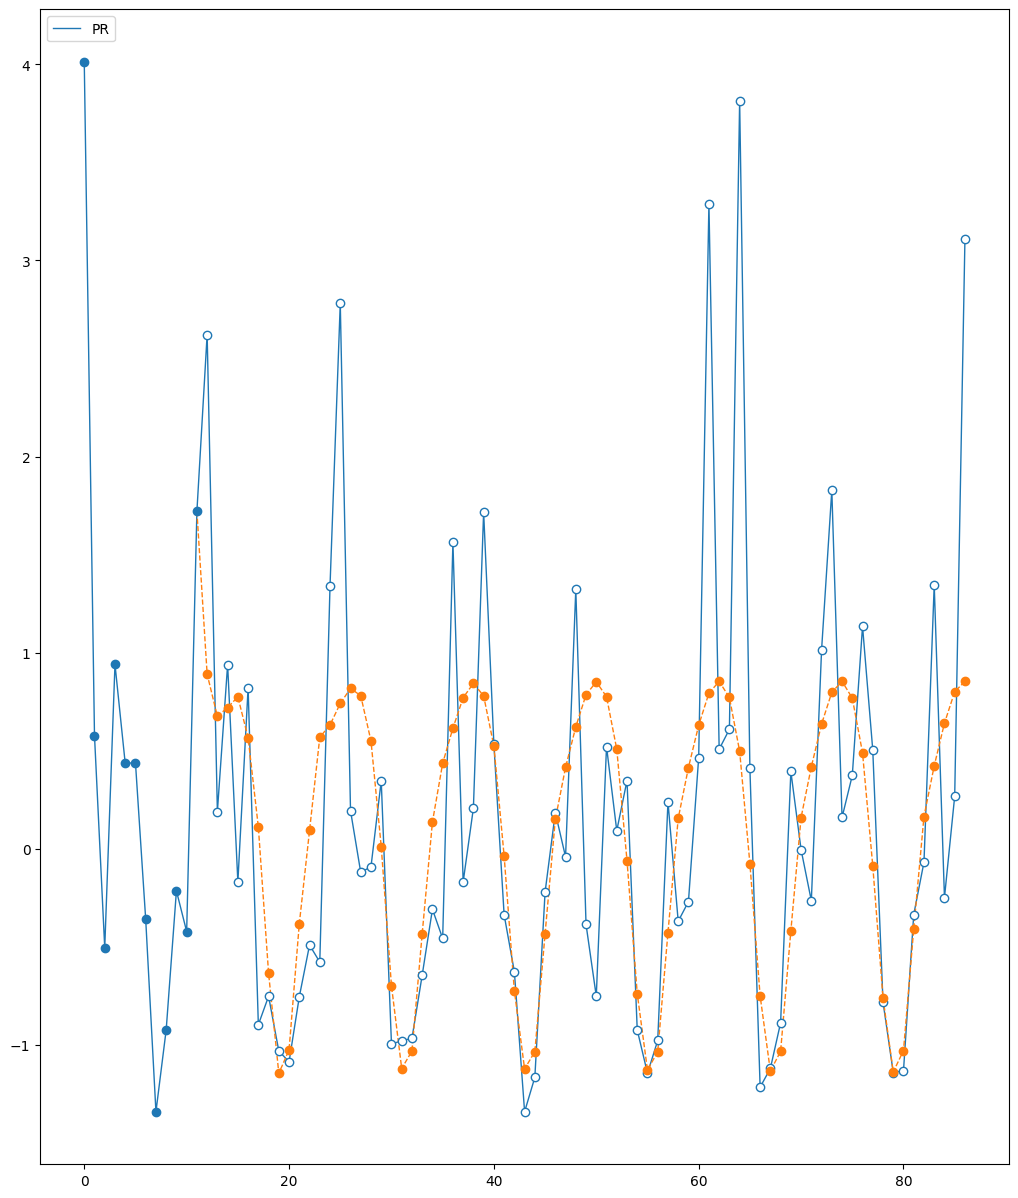

In [ ]:
fidle.scrawler.multivariate_serie(sequence_true[:,0:1], predictions=pred[:,0:1], labels=features[0:1], height=15, width=15, save_as='02-real-prediction-norm.png')

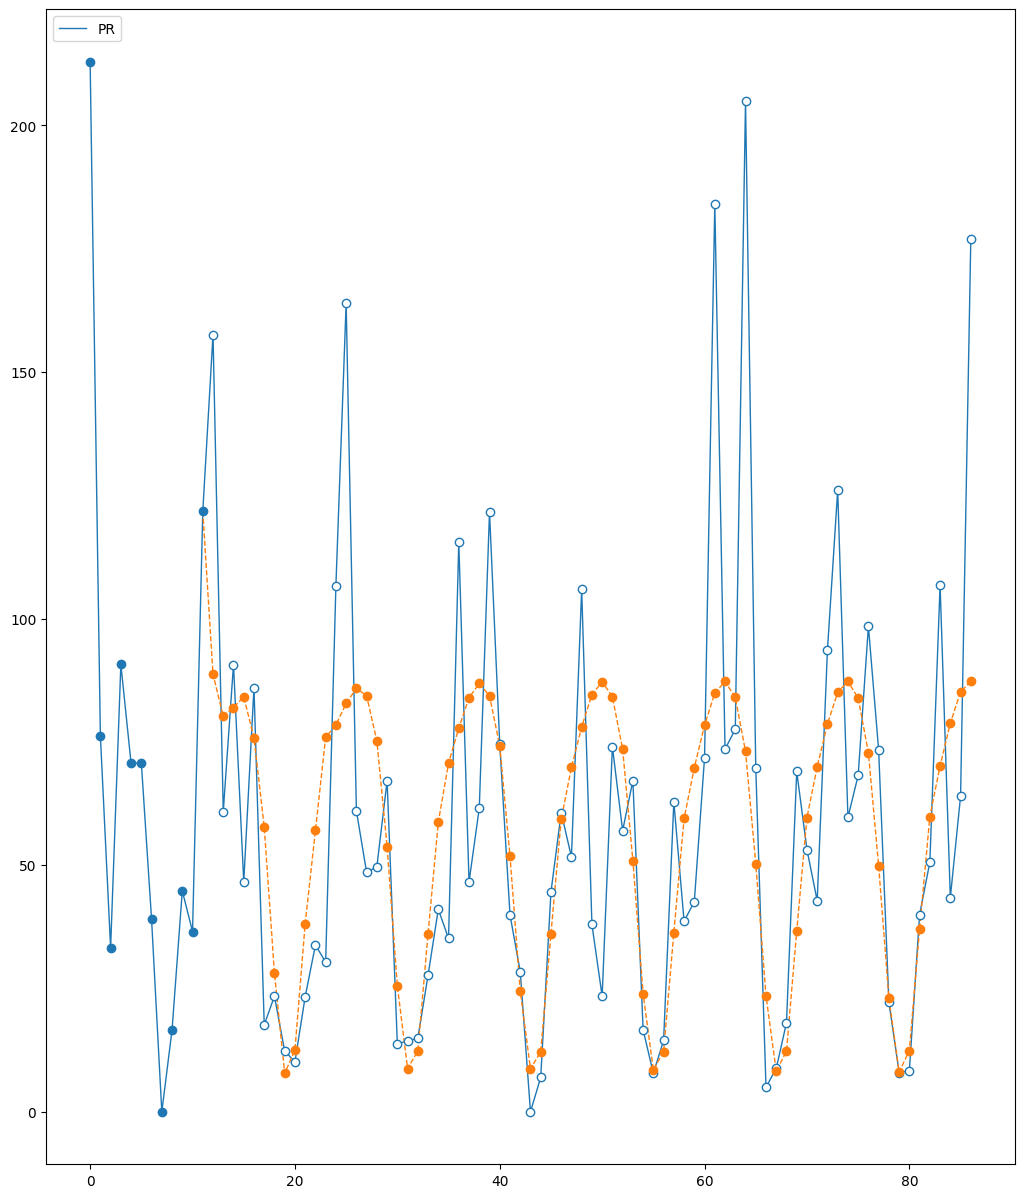

In [ ]:
pred = denormalize(mean, std, pred)
sequence_true = denormalize(mean, std, sequence_true)
fidle.scrawler.multivariate_serie(sequence_true[:,0:1], predictions=pred[:,0:1], labels=features[0:1], height=15, width=15, save_as='02-real-prediction-norm.png')

In [ ]:
features = ['PR', 'Tmax', 'Tmin', 'PET']
features_len = len(features)
#dates = df['Date']

#scale = 1
train_prop = .8
sequence_len = 12 # 12 mois
learning_rate = 0.00281763616945557
batch_size = 36
epochs= 100

#df = df[:int(scale * len(df))]
df = df[:len(df)]
train_len = int(train_prop * len(df))

dataset_train = df.loc[ :train_len-1, features]
dataset_test = df.loc[train_len:, features]
#print("=====Train Dataset Example=========")
#display(dataset_train.head(5))

#df.drop('Date', axis = 1, inplace = True)

#df.columns

mean = dataset_train.mean()
print('Moyenne:\n',mean)
std = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test = (dataset_test - mean) / std
#display(dataset_train.describe().style.format('{0:.2f}'))

dataset_train = dataset_train.to_numpy()
dataset_test = dataset_test.to_numpy()

print('Dataset: ', df.shape)
print('Train dataset: ', dataset_train.shape)
print('Test dataset: ', dataset_test.shape)

from keras.preprocessing.sequence import TimeseriesGenerator

train_generator = TimeseriesGenerator(dataset_train, dataset_train, length = sequence_len, batch_size = batch_size)
test_generator = TimeseriesGenerator(dataset_test, dataset_test, length = sequence_len, batch_size = batch_size)

x, y = train_generator[0]
x_val, y_val = test_generator[0]
print(f'nombre de batches disponibles: ', len(train_generator))
print('train batch x shape: ', x.shape)
print('train batch y shape: ', y.shape)

print('What a train batch looks like (x):')
print(x[0])
print('What a train batch looks like (y):')
print(y[0])
print('=======================================================================')
print('validation batch x shape: ', x_val.shape)
print('validation batch y shape: ', y_val.shape)
print('What a validation batch looks like (x):')
print(x_val[0])
print('What a validation batch looks like (y):')
print(y_val[0])

Moyenne:
 PR      53.294211
Tmax    23.006721
Tmin     9.492785
PET     56.066860
dtype: float64
Dataset:  (372, 5)
Train dataset:  (297, 4)
Test dataset:  (75, 4)
nombre de batches disponibles:  8
train batch x shape:  (36, 12, 4)
train batch y shape:  (36, 4)
What a train batch looks like (x):
[[-0.24899588 -1.21080959 -1.36544113 -1.19572101]
 [-0.24244899 -0.92325748 -1.21434583 -1.07898668]
 [ 0.29354887 -0.41106494 -0.72688148 -0.64544113]
 [ 0.98782362 -0.23479224 -0.75956765 -0.6205807 ]
 [-0.46742172  0.40992462 -0.055748   -0.08143997]
 [-0.75701357  0.66156272  0.70752828  0.26682498]
 [-1.08022236  1.44120273  1.50891969  1.34551109]
 [-1.02882021  1.41995782  1.71896482  1.76668397]
 [-0.71608544  0.88034923  1.08706971  1.15237219]
 [-0.17921768  0.08584979  0.31155016  0.34248571]
 [-0.07366539 -0.32409286 -0.24422699 -0.17818453]
 [ 0.02356752 -0.67932688 -0.4775231  -0.4524147 ]]
What a train batch looks like (y):
[ 2.90191959 -1.33611852 -1.0492502  -1.10521891]
valid

In [ ]:
optimized_model3 = tf.keras.models.load_model('optimized_model3.h5', custom_objects={"val_mse": val_mse })
optimized_model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 256)           267264    
                                                                 
 dropout_6 (Dropout)         (None, 12, 256)           0         
                                                                 
 lstm_7 (LSTM)               (None, 12, 128)           197120    
                                                                 
 dropout_7 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 12, 256)           394240    
                                                                 
 dropout_8 (Dropout)         (None, 12, 256)           0         
                                                                 
 flatten_2 (Flatten)         (None, 3072)             

In [ ]:
s = random.randint(0, len(dataset_test) - sequence_len)

sequence = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

print(sequence_true.shape)

pred = optimized_model3.predict(np.array([sequence]))

fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm.png')

(13, 4)
1/1 [==============================] - 4s 4s/step


In [ ]:
s = random.randint(0, len(dataset_test) - sequence_len)

sequence = dataset_test[s:s+sequence_len]
sequence_true = dataset_test[s:s+sequence_len+1]

print(sequence_true.shape)

pred = optimized_model3.predict(np.array([sequence]))

fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-prediction-norm.png')

(13, 4)
1/1 [==============================] - 0s 122ms/step


In [ ]:
def denormalize(mean, std, seq):
    nseq = seq.copy()
    for i, s in enumerate(nseq):
        s = s * std + mean
        nseq[i] = s
    return nseq

sequence_true = denormalize(mean, std, sequence_true)
pred = denormalize(mean, std, pred)
print(sequence_true)
print('=======================================================================================')
print(sequence_true.shape)
feat = 4

fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, height=8, save_as='03-prediction')

[[ 20.9092      21.56333333   5.5         36.27786636]
 [ 41.8675      26.95         9.7016129   55.73101044]
 [ 11.3128      30.28666667  12.8         67.72840118]
 [  5.3609      36.35        16.94032258 105.18698883]
 [ 28.3992      35.28870968  17.93064516 112.56311035]
 [ 52.1434      29.5         15.2         90.2443161 ]
 [ 65.8655      23.61774194  12.27903226  75.2930069 ]
 [ 77.7013      15.79666667   6.65        37.22249985]
 [ 21.187       13.93709677   2.72419355  21.38821983]
 [ 58.8583      13.85645161   3.15322581  21.85421562]
 [ 65.1119      15.10517241   3.65        22.40333939]
 [115.3423      15.34354839   3.48870968  22.40673828]
 [ 68.2832      21.98666667   7.52        43.06610107]]
(13, 4)


In [ ]:
sequence_true = denormalize(mean, std, sequence_true)
pred = denormalize(mean, std, pred)
print(sequence_true)
print('=======================================================================================')
print(sequence_true.shape)
feat = 4

fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, height=8, save_as='03-prediction')

[[ 884.94925992  216.18194124   41.08353863 1317.34501826]
 [1718.55724121  264.43841928   65.21665137 1993.67546954]
 [ 503.25629667  294.32996292   83.01308499 2410.79059846]
 [ 266.52186001  348.64836239  106.79416001 3713.11907511]
 [1182.86100753  339.14078817  112.48234858 3969.56582624]
 [2127.27704458  287.28260598   96.79814133 3193.60487461]
 [2673.06807153  234.58637013   80.0207643  2673.79040848]
 [3143.83227211  164.52123146   47.68887812 1350.18723585]
 [ 895.99864356  147.86226605   25.13993516  799.67438779]
 [2394.35950039  147.139806     27.60419926  815.87573503]
 [2643.09393362  158.32647702   30.4575577   834.96720537]
 [4640.98795858  160.46196927   29.53114262  835.08537528]
 [2769.23111989  219.97437485   52.68596105 1553.35261826]]
(13, 4)


In [ ]:
sequence_true

array([[ 884.94925992,  216.18194124,   41.08353863, 1317.34501826],
       [1718.55724121,  264.43841928,   65.21665137, 1993.67546954],
       [ 503.25629667,  294.32996292,   83.01308499, 2410.79059846],
       [ 266.52186001,  348.64836239,  106.79416001, 3713.11907511],
       [1182.86100753,  339.14078817,  112.48234858, 3969.56582624],
       [2127.27704458,  287.28260598,   96.79814133, 3193.60487461],
       [2673.06807153,  234.58637013,   80.0207643 , 2673.79040848],
       [3143.83227211,  164.52123146,   47.68887812, 1350.18723585],
       [ 895.99864356,  147.86226605,   25.13993516,  799.67438779],
       [2394.35950039,  147.139806  ,   27.60419926,  815.87573503],
       [2643.09393362,  158.32647702,   30.4575577 ,  834.96720537],
       [4640.98795858,  160.46196927,   29.53114262,  835.08537528],
       [2769.23111989,  219.97437485,   52.68596105, 1553.35261826]])

In [ ]:
pred

array([[2883.995   ,  201.44809 ,   44.595684, 1310.9272  ]],
      dtype=float32)

1/1 [==============================] - 0s 78ms/step
true values:  [[-1.23477075e+00  1.39511209e+00  1.17868832e+00  1.22021946e+00]
 [-1.22718047e+00  1.21038944e+00  1.04502324e+00  1.27975467e+00]
 [-8.53537564e-02  5.91982654e-01  8.01543127e-01  7.95496209e-01]
 [-5.91717125e-01  3.45829821e-01  4.89583060e-01  7.12790488e-01]
 [ 9.33482331e-02 -6.18040726e-01 -5.49485084e-01 -5.37359616e-01]
 [ 3.96757877e-02 -1.17876219e+00 -8.86380989e-01 -9.43429311e-01]
 [ 9.45437273e-01 -1.65047110e+00 -1.56818522e+00 -1.41468086e+00]
 [ 1.88549695e-01 -9.60333185e-01 -1.14967953e+00 -1.10173734e+00]
 [-6.73990738e-01 -6.25674488e-01 -1.00825209e+00 -8.81470735e-01]
 [ 6.66377188e-02 -3.82510344e-01 -7.09078193e-01 -7.36905134e-01]
 [-7.52636408e-01  5.93927103e-01  1.05229238e-02  8.90084465e-02]
 [-8.20687377e-01  1.09801949e+00  1.01858976e+00  6.83253295e-01]
 [-1.20343668e+00  1.51646011e+00  1.48140041e+00  1.45628198e+00]
 [-1.24126735e+00  1.60864139e+00  1.65381713e+00  1.94462054e+

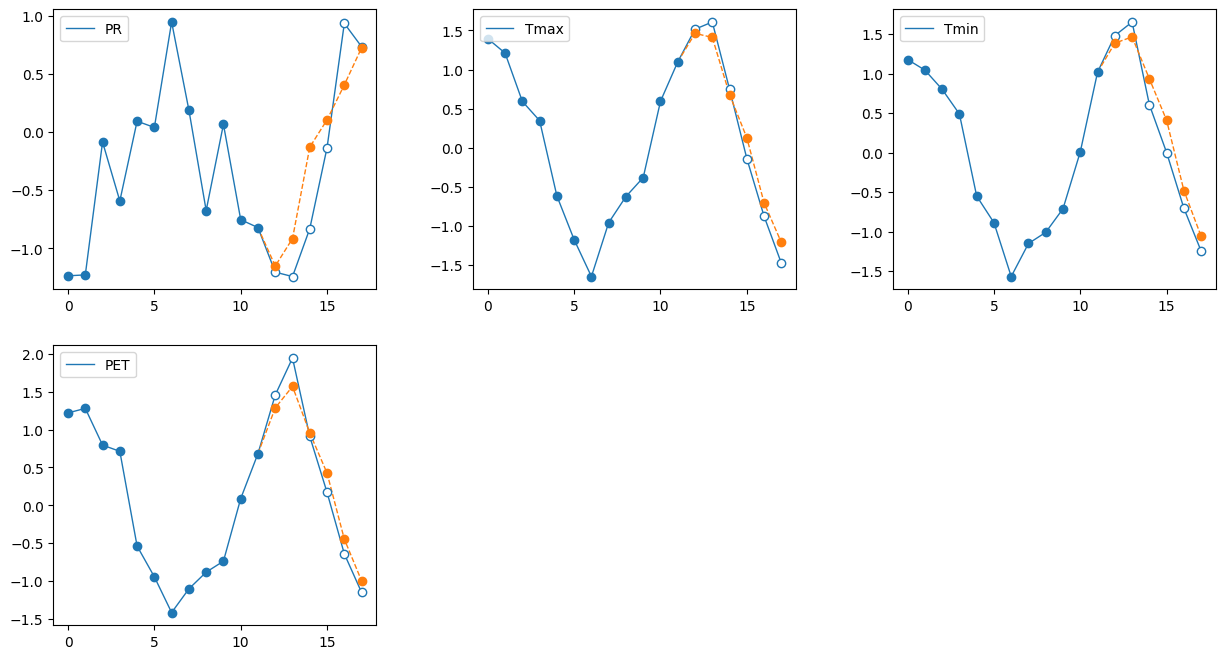

In [ ]:
iterations = 6 # 6 mois

s = random.randint(0, len(dataset_test)-sequence_len-iterations)
sequence_pred = dataset_test[s:s+sequence_len].copy()
sequence_true = dataset_test[s:s+sequence_len+iterations].copy()

sequence_pred = list(sequence_pred)
for i in range(iterations):
    sequence = sequence_pred[-sequence_len:]
    #print(sequence)
    pred = optimized_model3.predict(np.array([sequence]))
    sequence_pred.append(pred[0])

pred = np.array(sequence_pred[-iterations:])
print('true values: ', sequence_true)
print('predicted values: ', pred)
fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-long-prediction-norm.png')

1/1 [==============================] - 0s 106ms/step
true values:  [[-0.11138545  0.21908056  0.49126791  0.63610913]
 [-0.13328636 -0.44650912 -0.20186228 -0.21387062]
 [ 1.2211811  -1.36564534 -1.10990494 -1.08475391]
 [ 2.70595533 -1.46826903 -1.305348   -1.24600538]
 [ 3.43104623 -1.5834442  -1.52461971 -1.40677289]
 [ 1.12156978 -0.99403954 -1.08687861 -1.05949623]
 [-0.8142134  -0.16111923 -0.69515007 -0.56918647]
 [-0.28728665  0.4401716   0.03635735 -0.00965997]
 [-1.05548296  0.8126296   0.57579142  0.33541834]
 [-1.20512368  1.48945387  1.2966281   1.41283147]
 [-0.62590226  1.37098652  1.46904482  1.62498923]
 [-0.02893333  0.72481732  0.9936352   0.98303866]
 [ 0.31606324  0.06820572  0.48509012  0.55299744]
 [ 0.61363506 -0.80482785 -0.49493326 -0.54201619]
 [-0.80722904 -1.01240378 -1.17842234 -0.9974541 ]
 [ 0.1398905  -1.02140586 -1.10372715 -0.98405077]
 [ 0.29711647 -0.88201643 -1.01723798 -0.96825644]
 [ 1.55999281 -0.85540753 -1.04531888 -0.96815868]
 [ 0.37684826 -

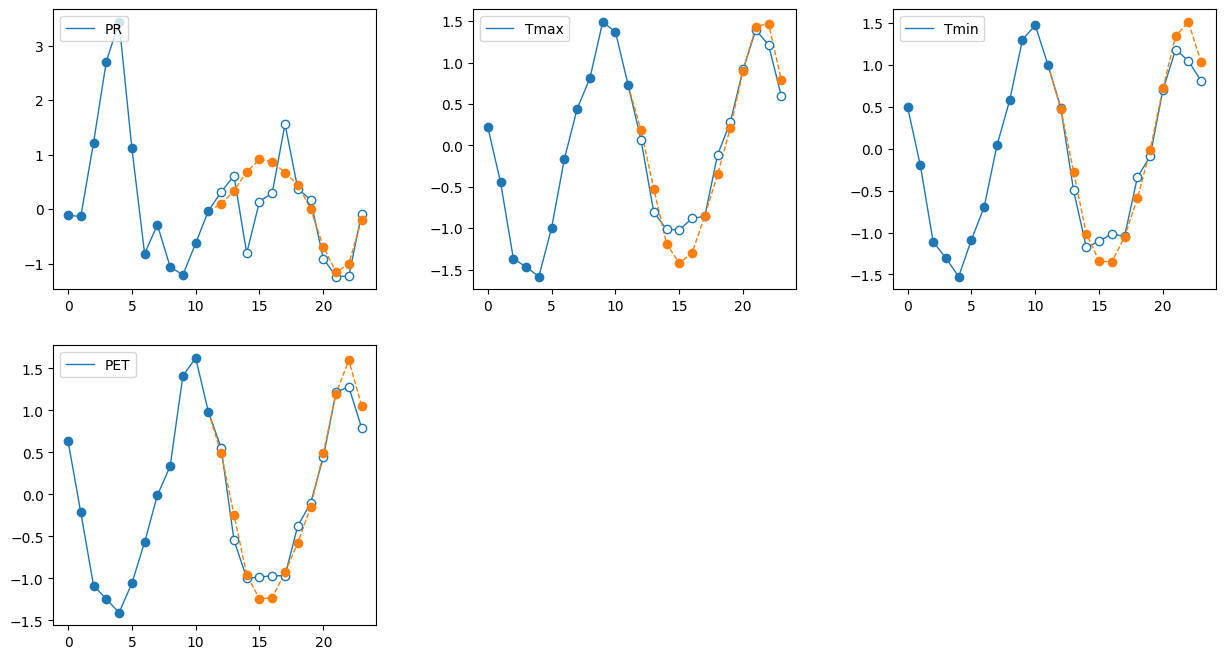

In [ ]:
iterations = 12 # 5 mois

s = random.randint(0, len(dataset_test)-sequence_len-iterations)
sequence_pred = dataset_test[s:s+sequence_len].copy()
sequence_true = dataset_test[s:s+sequence_len+iterations].copy()

sequence_pred = list(sequence_pred)
for i in range(iterations):
    sequence = sequence_pred[-sequence_len:]
    #print(sequence)
    pred = optimized_model3.predict(np.array([sequence]))
    sequence_pred.append(pred[0])

pred = np.array(sequence_pred[-iterations:])
print('true values: ', sequence_true)
print('predicted values: ', pred)
fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-real-prediction-norm.png')

In [ ]:
dataset = []
for i in dataset_train:
	dataset.append(i)

dataset = np.array(dataset)

iterations = len(dataset_test) # 5 mois

s = random.randint(0, len(dataset)-sequence_len-iterations)
sequence_pred = dataset[s:s+sequence_len].copy()
sequence_true = dataset[s:s+sequence_len+iterations].copy()

sequence_pred = list(sequence_pred)
for i in range(iterations):
    sequence = sequence_pred[-sequence_len:]
    #print(sequence)
    pred = optimized_model3.predict(np.array([sequence]))
    sequence_pred.append(pred[0])

pred = np.array(sequence_pred[-iterations:])
print('true values: ', sequence_true)
print('predicted values: ', pred)

1/1 [==============================] - 0s 82ms/step
true values:  [[ 1.62123290e+00 -7.55304418e-01 -8.33027281e-01 -8.01353505e-01]
 [ 1.61898272e+00 -4.63997159e-01 -5.18146801e-01 -6.32574991e-01]
 [-1.41696248e-01  2.60490117e-01  6.49998678e-02 -7.23346386e-02]
 [-8.69261091e-01  6.61190634e-01  6.54137128e-01  2.72924604e-01]
 [-1.23531129e+00  1.33101729e+00  1.24664410e+00  1.16787713e+00]
 [-1.13607710e+00  1.28924764e+00  1.44433362e+00  1.48924357e+00]
 [-6.26158704e-01  4.51706266e-01  5.89139207e-01  5.50636672e-01]
 [-1.57035183e-01 -2.63430850e-01 -1.92782785e-01 -1.35927019e-01]
 [ 4.35257399e-01 -5.95715571e-01 -4.80424793e-01 -4.34124821e-01]
 [ 8.51658829e-01 -7.25417518e-01 -7.13964269e-01 -6.00256034e-01]
 [ 1.32147626e+00 -1.00592228e+00 -9.13338652e-01 -8.90310651e-01]
 [-7.09704486e-01 -8.25983594e-01 -1.05641083e+00 -9.97861279e-01]
 [-1.40200318e-01 -7.00571781e-01 -1.30422477e+00 -1.02478173e+00]
 [ 2.29206296e-01 -3.95161265e-01 -8.46038097e-01 -7.31817742e-

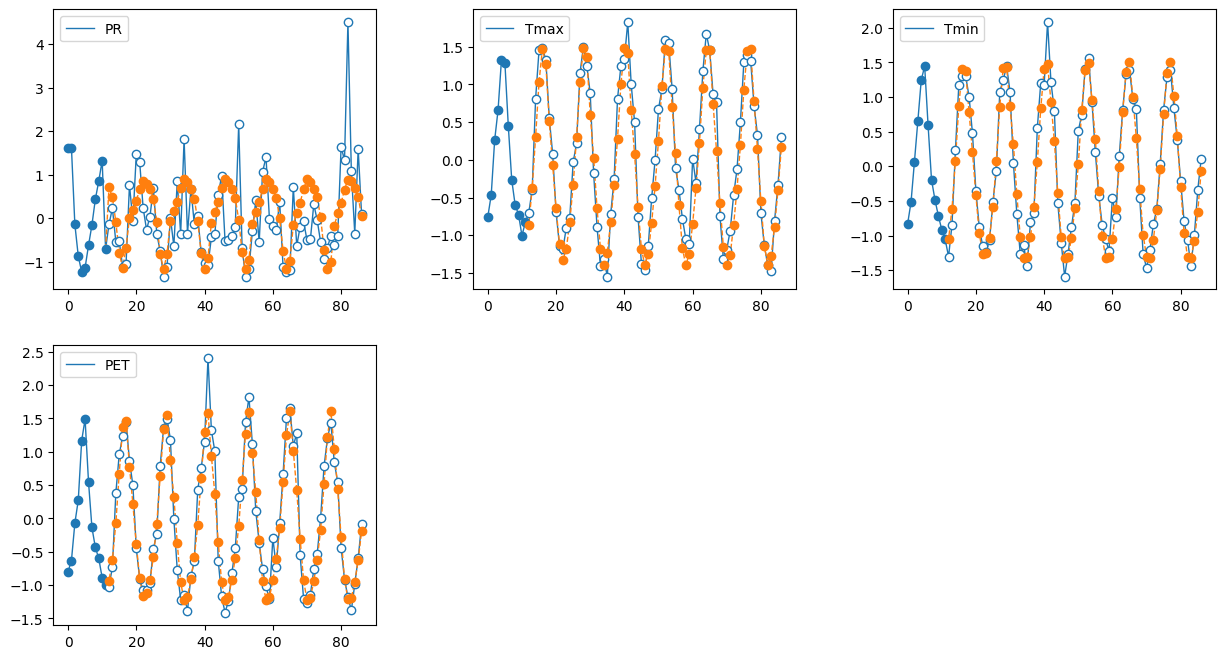

In [ ]:
fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-real-prediction-norm.png')

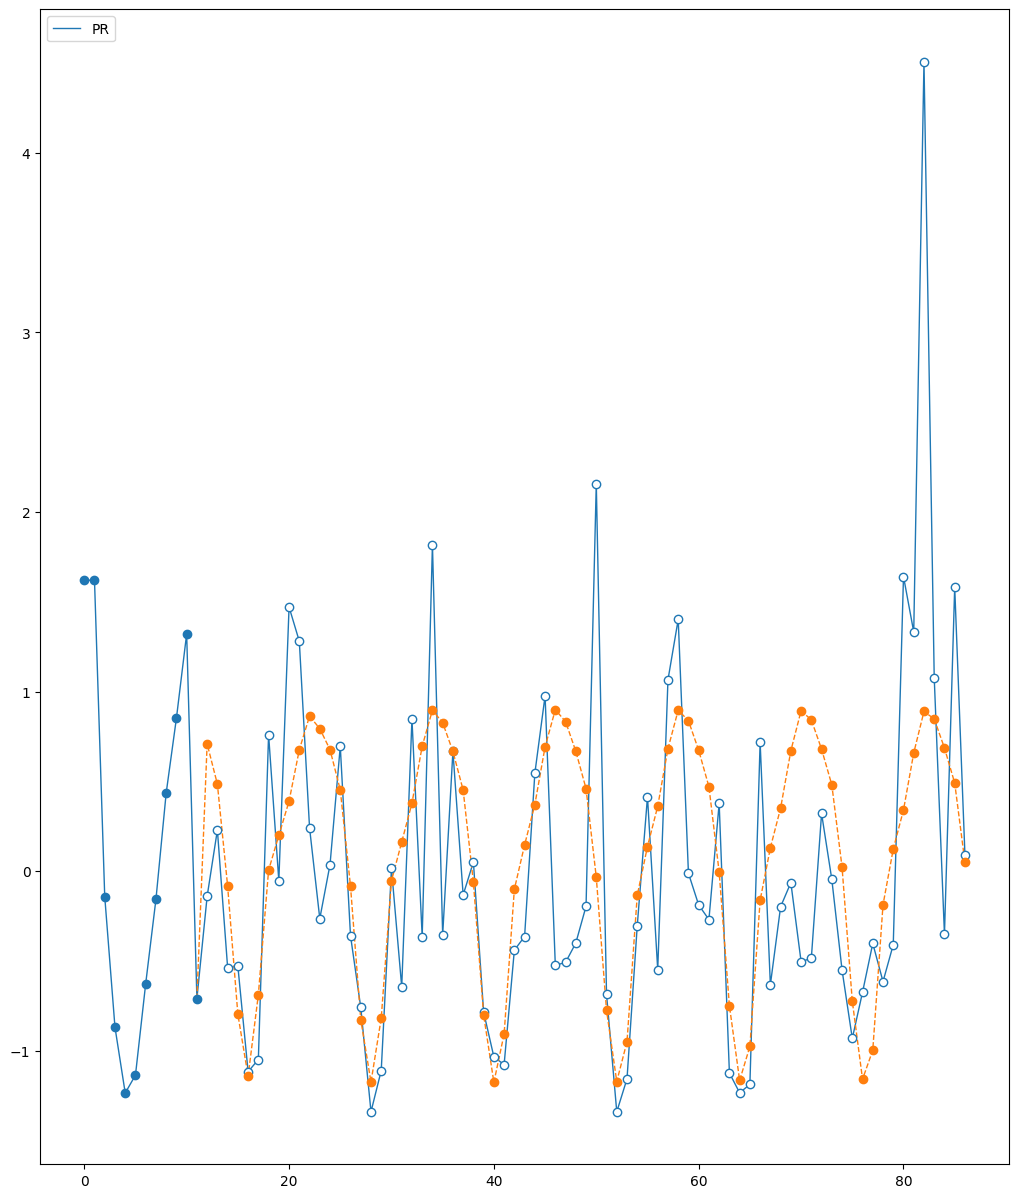

In [ ]:
fidle.scrawler.multivariate_serie(sequence_true[:,0:1], predictions=pred[:,0:1], labels=features[0:1], height=15, width=15, save_as='02-real-prediction-norm.png')

In [ ]:
pred = denormalize(mean, std, pred)
sequence_true = denormalize(mean, std, sequence_true)
fidle.scrawler.multivariate_serie(sequence_true[:,0:1], predictions=pred[:,0:1], labels=features[0:1], height=15, width=15, save_as='02-real-prediction-norm.png')

In [ ]:
dataset = []
for i in dataset_train:
	dataset.append(i)

dataset = np.array(dataset)

iterations = len(dataset_test) # 5 mois

s = random.randint(0, len(dataset)-sequence_len-iterations)
sequence_pred = dataset[s:s+sequence_len].copy()
sequence_true = dataset[s:s+sequence_len+iterations].copy()

sequence_pred = list(sequence_pred)
for i in range(iterations):
    sequence = sequence_pred[-sequence_len:]
    #print(sequence)
    pred = optimized_model4.predict(np.array([sequence]))
    sequence_pred.append(pred[0])

pred = np.array(sequence_pred[-iterations:])
print('true values: ', sequence_true)
print('predicted values: ', pred)

1/1 [==============================] - 0s 81ms/step
true values:  [[-1.02882021  1.41995782  1.71896482  1.76668397]
 [-0.71608544  0.88034923  1.08706971  1.15237219]
 [-0.17921768  0.08584979  0.31155016  0.34248571]
 [-0.07366539 -0.32409286 -0.24422699 -0.17818453]
 [ 0.02356752 -0.67932688 -0.4775231  -0.4524147 ]
 [ 2.90191959 -1.33611852 -1.0492502  -1.10521891]
 [-1.03920624 -0.56525768 -0.85121969 -0.81324033]
 [-0.01029329 -0.50432647 -0.80606962 -0.75360345]
 [ 0.51680442 -0.37804531 -0.59301048 -0.71094809]
 [ 0.79914542  0.1989159   0.19361039 -0.15648978]
 [-0.84873291  1.21187778  1.18456659  0.78129147]
 [-1.17797822  1.26800274  1.27079367  1.08090391]
 [-1.08542669  1.15061564  1.22474099  1.2555067 ]
 [-0.82936125  1.11401919  1.48053926  1.60988894]
 [-0.02361586  0.44557285  0.71142216  0.98108364]
 [ 0.92627429 -0.8431527  -0.31386762 -0.43713908]
 [ 1.0313338  -1.44990479 -1.24020032 -1.16827928]
 [-0.28284663 -1.33251769 -1.2958005  -1.16509744]
 [ 0.66734773 -1

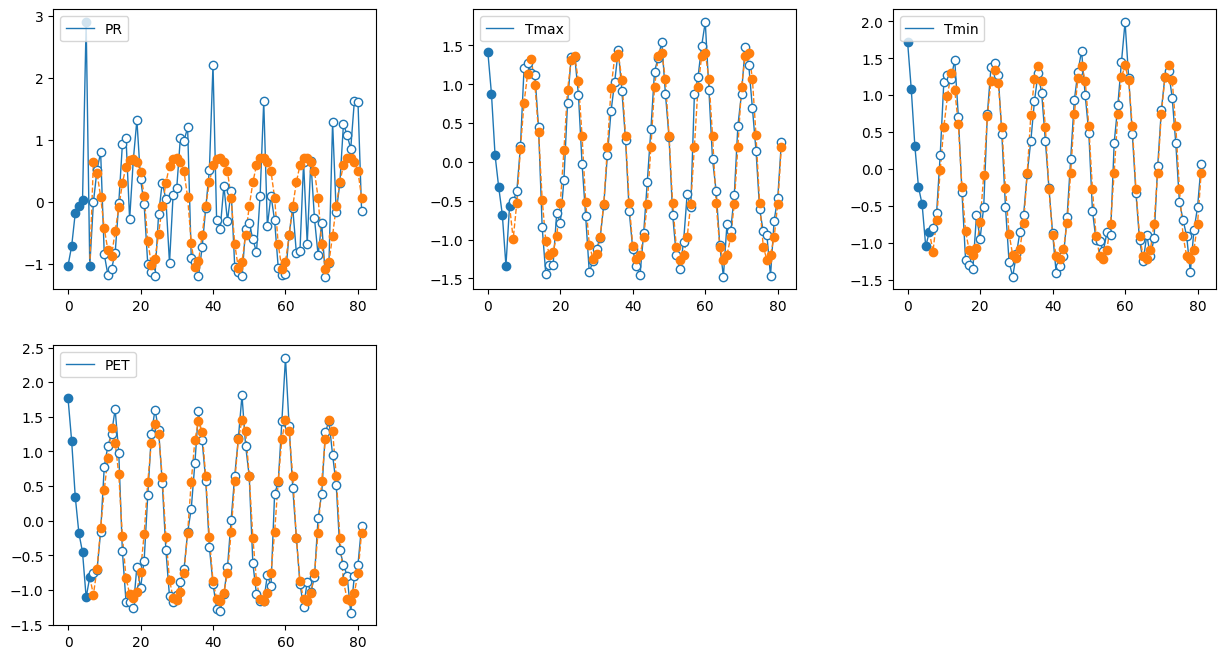

In [ ]:
fidle.scrawler.multivariate_serie(sequence_true, predictions=pred, labels=features, save_as='02-real-prediction-norm.png')

In [ ]:
fidle.scrawler.multivariate_serie(sequence_true[:,0:1], predictions=pred[:,0:1], labels=features[0:1], height=15, width=15, save_as='02-real-prediction-norm.png')

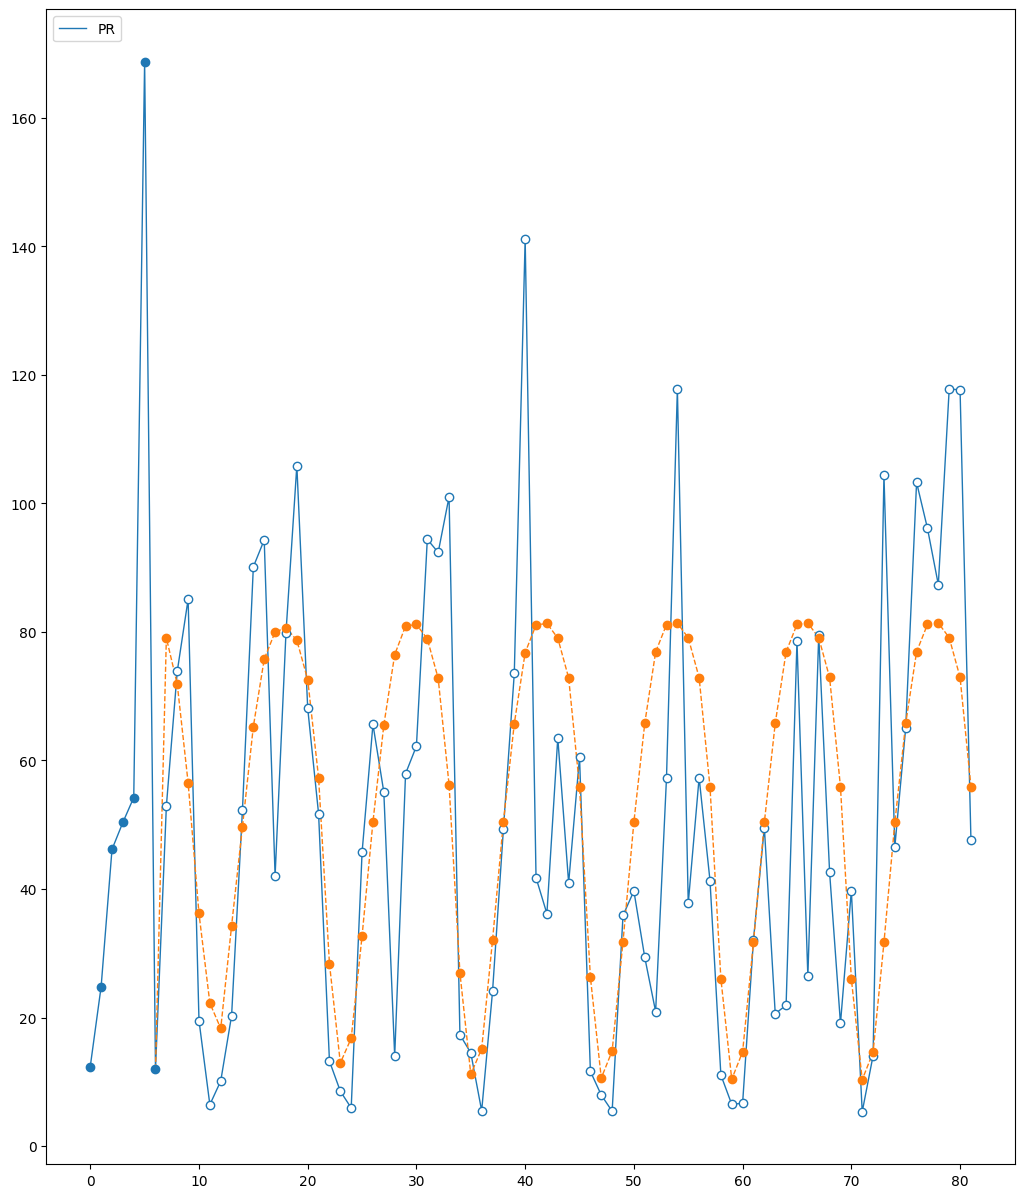

In [ ]:
pred = denormalize(mean, std, pred)
sequence_true = denormalize(mean, std, sequence_true)
fidle.scrawler.multivariate_serie(sequence_true[:,0:1], predictions=pred[:,0:1], labels=features[0:1], height=15, width=15, save_as='02-real-prediction-norm.png')